In [ ]:
#pip install similaritymeasures

In [ ]:
#pip install tslearn

In [ ]:
#pip install frechetdist

In [ ]:
pip install matplotlib==3.1.3

In [ ]:
pip install trjtrypy

In [ ]:
import glob
import numpy as np 
import time
import math
import random
from scipy import linalg as LA
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import NuSVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
import statsmodels.api as sm
from autograd import grad
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from termcolor import colored
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn.svm import LinearSVC
from termcolor import colored
from scipy.stats import entropy
import os
import ast
import csv
import json 
import scipy.io
#import similaritymeasures
#import tslearn
#from tslearn.metrics import dtw
#from scipy.spatial.distance import directed_hausdorff
#from frechetdist import frdist

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import sampler
import torchvision.transforms as T

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import trjtrypy as tt
from trjtrypy.featureMappings import curve2vec

def ExpCurve2Vec(points,curves,mu):
    D=tt.distsbase.DistsBase()
    return [np.exp(-1*np.power(D.APntSetDistACrv(points,curve),2)/(mu)**2) for curve in curves]

# Reading data

In [ ]:
mat = scipy.io.loadmat('/content/gdrive/My Drive/Research/Characters/mixoutALL_shifted.mat')

s = set()
for i in range(len(mat['mixout'][0])):
    s.add(mat['mixout'][0][i].shape[1])
print("length of data points belongs to: \n", s)

labels = mat['consts'][0][0][4][0]
print(labels)

Data = [0] * len(mat['mixout'][0])
for j in range(len(Data)):
    Data[j] = [0] * len(mat['mixout'][0][j][0])
    Data[j][0] = np.zeros(2)
    for i in range(1, len(mat['mixout'][0][j][0])):
        Data[j][i] = Data[j][i-1] + mat['mixout'][0][j][:2, i]
    Data[j] = np.array(Data[j])
        
Data = np.array(Data, dtype='object')
print(Data.shape)


data = [0] * 20
for i in range(1, 21):
    I = np.where(labels == i)[0]
    data[i-1] = Data[I]
data = np.array(data, dtype='object')

length of data points belongs to: 
 {160, 130, 162, 163, 196, 198, 166, 109, 174, 205, 176, 177, 178, 173, 183, 152}
[ 1  1  1 ... 20 20 20]
(2858,)


In [ ]:
mat = scipy.io.loadmat('/content/gdrive/My Drive/Research/Characters/mixoutALL_shifted.mat')

s = set()
for i in range(len(mat['mixout'][0])):
    s.add(mat['mixout'][0][i].shape[1])
print("length of data points belongs to: \n", s)

length of data points belongs to: 
 {160, 130, 162, 163, 196, 198, 166, 109, 174, 205, 176, 177, 178, 173, 183, 152}


In [ ]:
labels = mat['consts'][0][0][4][0]
labels

array([ 1,  1,  1, ..., 20, 20, 20], dtype=uint8)

In [ ]:
Data = [0] * len(mat['mixout'][0])
for j in range(len(Data)):
    Data[j] = [0] * len(mat['mixout'][0][j][0])
    Data[j][0] = np.zeros(2)
    for i in range(1, len(mat['mixout'][0][j][0])):
        Data[j][i] = Data[j][i-1] + mat['mixout'][0][j][:2, i]
    Data[j] = np.array(Data[j])
        
Data = np.array(Data)
Data.shape

/Users/hasan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':


(2858,)

In [ ]:
data = [0] * 20
for i in range(1, 21):
    I = np.where(labels == i)[0]
    data[i-1] = Data[I]
data = np.array(data, dtype='object')

## removes stationary points

In [ ]:
def remove_segments(traj): 
    p2 = traj[:,:2][1:]
    p1 = traj[:,:2][:-1]
    L = ((p2-p1)*(p2-p1)).sum(axis =1)
    I = np.where(L>1e-16)[0]
    return traj[I]

In [ ]:
for i in range(len(data)):
    data[i] = np.array(list(map(remove_segments, data[i])), dtype='object')

# Classifiers, get $\mu$, pairs

In [ ]:
CC = [100, 100, 10]
number_estimators = [50, 50]


clf0 = [make_pipeline(LinearSVC(dual=False, C=CC[0], tol=1e-5, 
                               class_weight ='balanced', max_iter=1000)), 
        "SVM, LinearSVC, C = "+str(CC[0])]
clf1 = [make_pipeline(StandardScaler(), svm.SVC(C=CC[1], kernel='rbf', gamma='auto', max_iter=200000)),
        "Gaussian SVM, C="+str(CC[1])+", gamma=auto"]
clf2 = [make_pipeline(StandardScaler(), svm.SVC(C=CC[2], kernel='poly', degree=3, max_iter=400000)),
        "Poly kernel SVM, C="+str(CC[2])+", deg=auto"]
clf3 = [DecisionTreeClassifier(), "Decision Tree"]
clf4 = [RandomForestClassifier(n_estimators=number_estimators[0]), 
         "RandomForestClassifier, n="+str(number_estimators[0])]
clf5 = [KNeighborsClassifier(n_neighbors=5), "KNN"]
clf6 = [LogisticRegression(solver='newton-cg'), "Logistic Regression"]

clff = [clf0, clf1, clf2, clf3, clf4, clf5, clf6]
classifs = [item[0] for item in clff]
keys = [item[1] for item in clff]

In [ ]:
def get_mu(data_1, data_2):
    a = np.mean([np.mean(data_1[i], 0) for i in range(len(data_1))], 0)
    b = np.mean([np.mean(data_2[i], 0) for i in range(len(data_2))], 0)
    c = abs(a-b)
    return max(c)

In [ ]:
pairs = [[16,18], [10,18], [10,16], [2,8], [3,11]]
pairs = np.array(pairs) - 1
# (u,w), (n,w), (n,u), (b,c), (c,o)

# Choosing pairs (Don't run again)

In [ ]:
def classify(n, m, k = 20, t = 10, std_x = 20, std_y = 20, clf = clf):
    
    I = np.where(labels == n)[0] 
    J = np.where(labels == m)[0]
    K = np.concatenate((I, J), 0)
    
    Min = np.min([np.min(Data[K][i], 0) for i in range(len(Data[K]))], 0)
    Max = np.max([np.max(Data[K][i], 0) for i in range(len(Data[K]))], 0)
    Mean = np.mean([np.mean(Data[K][i], 0) for i in range(len(Data[K]))], 0)
    Std = np.std([np.std(Data[K][i], 0) for i in range(len(Data[K]))], 0)
    
    data_1 = Data[I]
    data_2 = Data[J]
    
    Q = np.ones((k,2))
    Q[:,0] = np.random.normal(Mean[0], Std[0] + std_x, k)
    Q[:,1] = np.random.normal(Mean[1], Std[1] + std_y, k)
    
    n_1 = len(data_1)
    n_2 = len(data_2)
    
    # unsigned feature mapping
    proj_1 = [0] * n_1 
    proj_2 = [0] * n_2 
    for i in range(n_1):
        proj_1[i] = np.concatenate((Curve2Vec(Q, [data_1[i].tolist()])[0], [1]), axis = 0)
    for i in range(n_2):
        proj_2[i] = np.concatenate((Curve2Vec(Q, [data_2[i].tolist()])[0],[-1]), axis = 0)
    proj_1 = np.array(proj_1)
    proj_2 = np.array(proj_2)
    
    error_tr = np.zeros((len(clf), t))
    error_ts = np.zeros((len(clf), t))
    
    for i in range(t): 
        R1 = random.sample(range(n_1), n_1//3)
        R = np.sort(R1)
        R_c = np.sort(list(set(range(n_1)) - set(R)))
        S1 = random.sample(range(n_2), n_2//3)
        S = np.sort(S1)
        S_c = np.sort(list(set(range(n_2)) - set(S)))

        data_tr = np.insert(proj_1[R_c], len(R_c), proj_2[S_c], axis = 0)
        data_ts = np.insert(proj_1[R], len(R), proj_2[S], axis = 0)

        random.shuffle(data_tr)
        random.shuffle(data_ts)

        for s in range(len(clf)):
            model = clf[s][0]
            model.fit(data_tr[:,:-1], data_tr[:,-1])
            y_pre = model.predict(data_ts[:,:-1])
            error_ts[s][i] = 1 - metrics.accuracy_score(data_ts[:,-1], y_pre)
            x_pre = model.predict(data_tr[:,:-1])
            error_tr[s][i] = 1 - metrics.accuracy_score(data_tr[:,-1], x_pre)

    Dic = {}
    models = ["L SVM, C=1000", "G SVM, C=1", "G SVM, C=2", "G SVM, C=0.5", 
              "P SVM, C=1000", "DTree", "RForest, n=100"]
    for l in range(len(models)): 
        Dic[l+1] = [models[l], np.round(np.mean(error_tr[l]), decimals = 4), 
                    np.round(np.mean(error_ts[l]), decimals = 4),
                    np.round(np.std(error_ts[l]), decimals = 4)]
    
    print("n, m =", (n, m))
    
    print(pd.DataFrame.from_dict(Dic, orient='index', 
                                 columns=['Classifier', 'Train', 'Test', 'Std']))
    
    return n, m, t

In [ ]:
for n in range(1, 20):
    for m in range(n+1, 21):
        classify(n, m, k=10, t=3, clf=clf)

In [ ]:
pairs = [[16,18], [10,18], [10,16], [2,8], [3,11]]

In [ ]:
for n, m in pairs:
    classify(n, m, k = 10, t = 20, clf = clf)

# Pairs and plotting (Extra)

In [ ]:
pairs = [[16,18], [10,18], [10,16], [2,8], [3,11]]
pairs = np.array(pairs) - 1
# (u,w), (n,w), (n,u), (b,c), (c,o)

In [ ]:
for i in range(len(pairs)):
    print("pairs =", pairs[i])
    print("mu =", get_mu(data[pairs[i][0]], data[pairs[i][1]]))

pairs = [15 17]
mu = 5.451060274876726
pairs = [ 9 17]
mu = 4.881740063729723
pairs = [ 9 15]
mu = 1.4608140207068985
pairs = [1 7]
mu = 12.866364683667523
pairs = [ 2 10]
mu = 3.8156332649843874


In [ ]:
len(data[2]), len(data[10])

(142, 141)

pairs = 15, 17
mu = 5.451060274876726


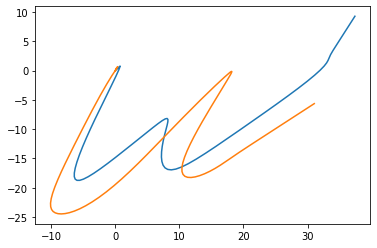

In [ ]:
i = 0 
m, n = pairs[i]
mu = get_mu(data[m], data[n])
print("pairs =", f"{m},", n)
print("mu =", mu)
plt.plot(data[n][0][:,0], data[n][0][:,1])
plt.plot(data[m][0][:,0], data[m][0][:,1])
plt.show()

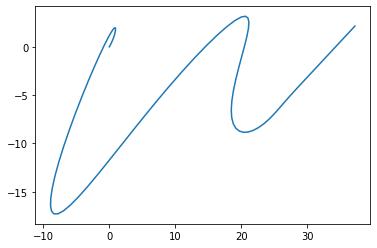

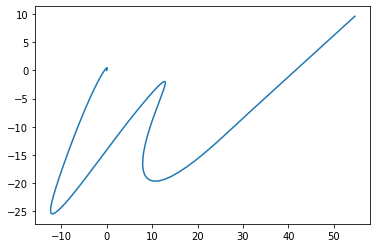

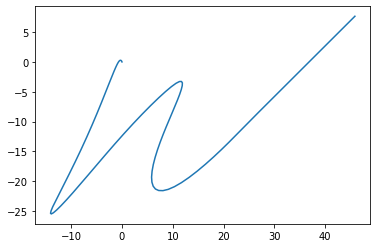

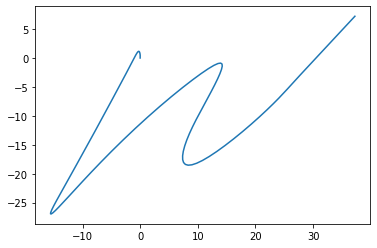

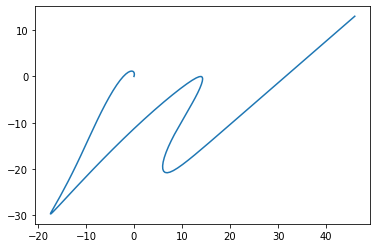

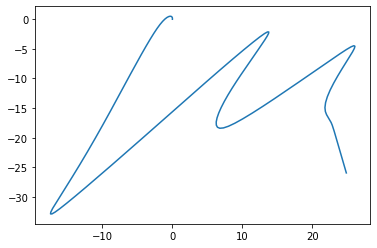

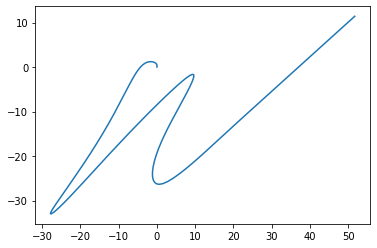

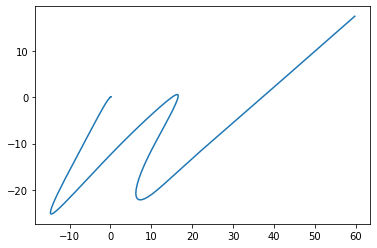

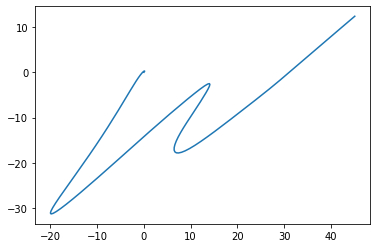

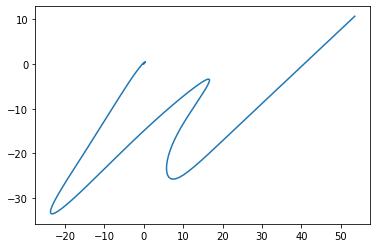

In [ ]:
m= 9
n = 17
for i in range(10):
    #plt.plot(data[n][i][:,0], data[n][i][:,1])
    plt.plot(data[m][i][:,0], data[m][i][:,1])
    plt.show()

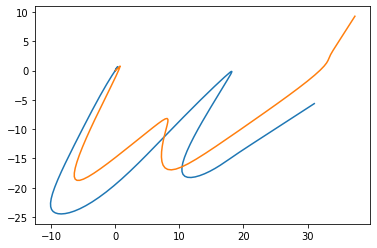

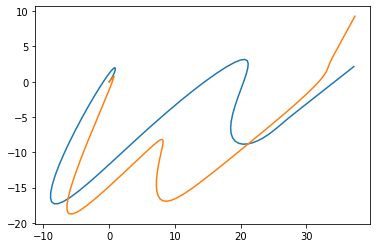

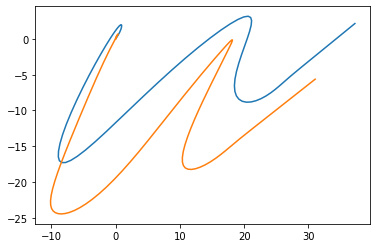

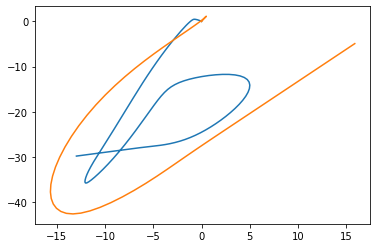

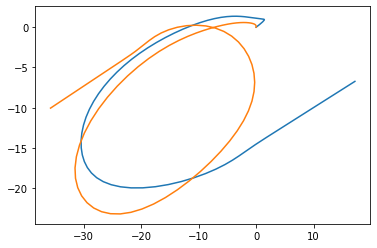

In [ ]:
for n, m in pairs:
    plt.plot(data[n][0][:,0], data[n][0][:,1])
    plt.plot(data[m][0][:,0], data[m][0][:,1])
    plt.show()

0


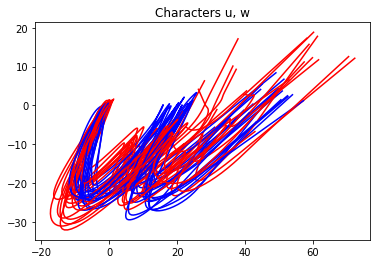

1


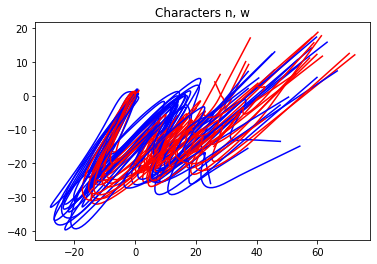

2


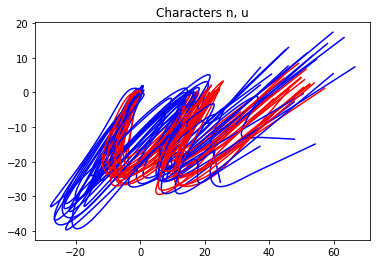

3


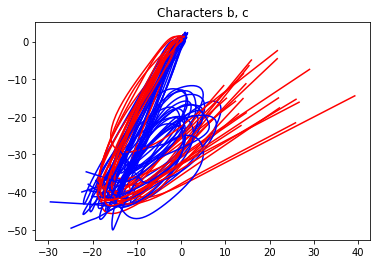

4


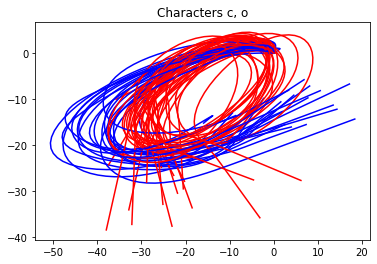

In [ ]:
characters = [['u, w'], ['n, w'], ['n, u'], ['b, c'], ['c, o']]
for j in range(len(pairs)):
    for i in range(20):
        plt.plot(data[pairs[j][0]][i][:,0], data[pairs[j][0]][i][:,1], color='blue')
        plt.plot(data[pairs[j][1]][i][:,0], data[pairs[j][1]][i][:,1], color='red')
    plt.title(f'Characters {characters[j][0]}')
    print(j)
    plt.show()

# KNN

## KNN with $d_Q^{\pi}$ distance with matrix storing method

### Calculate distance matrix

In [ ]:
def calculate_dists_d_Q_pi(data1, data2, p, path): 
    start_time = time.time() 
    data = np.concatenate((data1, data2), 0)
    n = len(data)
    A = []
    for i in range(n-1):
        for j in range(i+1, n):
            A.append(d_pi_QQ(Q, data[i], data[j], p=p))
    A = np.array(A)
    tri = np.zeros((n, n))
    tri[np.triu_indices(n, 1)] = A
    for i in range(1, n):
        for j in range(i):
            tri[i][j] = tri[j][i]
    np.savetxt(path, tri, delimiter=',')

    total_time = time.time() - start_time
    return total_time

In [ ]:
paths_d_Q_pi = []
for i in range(len(pairs)):
    paths_d_Q_pi.append('/content/gdrive/My Drive/traj-dist/Calculated Distance Matrices (Characters Pairs['+str(i)+'])/d_Q_pi.csv')

for i in range(len(pairs)):
    calculate_dists_d_Q_pi(data[pairs[i][0]], data[pairs[i][1]], p=1, path=paths_d_Q_pi[i])

In [ ]:
def KNN_with_dists(n_1, n_2, path_to_dists):
    '''path example: '/content/gdrive/My Drive/traj-dist/Calculated Distance Matrices (Characters Pairs['+str(0)+'])/d_Q_pi.csv'
       path_to_dists: the path to the corresponding distance matrix
       n_1: len(data_1)
       n_2: len(data_2)'''

    I_1, J_1, y_train_1, y_test_1 = train_test_split(np.arange(n_1), 
                                                np.ones(n_1), test_size=0.3)
    I_2, J_2, y_train_2, y_test_2 = train_test_split(np.arange(n_1, n_1+n_2), 
                                                np.ones(n_2), test_size=0.3)
    labels = np.array([1] * n_1 + [0] * n_2)
    I = np.concatenate((I_1, I_2), 0)
    np.random.shuffle(I)
    J = np.concatenate((J_1, J_2), 0)
    np.random.shuffle(J)

    dist_matrix = np.array(pd.read_csv(path_to_dists, header=None))

    D_train = dist_matrix[I][:, I]
    D_test = dist_matrix[J][:,I]
    train_labels = labels[I]
    test_labels = labels[J]

    clf = KNeighborsClassifier(n_neighbors=5, metric='precomputed')
    
    #Train the model using the training sets
    clf.fit(D_train, list(train_labels))

    #Predict labels for train dataset
    train_pred = clf.predict(D_train)
    train_error = sum(train_labels != train_pred)/len(I)
    
    #Predict labels for test dataset
    test_pred = clf.predict(D_test)
    test_error = sum((test_labels != test_pred))/len(J)
        
    return train_error, test_error

In [ ]:
def KNN_average_error(data1, data2, num_trials, path_to_dists, pair):

    '''path_to_dists: the path to the corresponding distance matrix'''

    Start_time = time.time()

    train_errors = np.zeros(num_trials)
    test_errors = np.zeros(num_trials)

    for i in range(num_trials):
        train_errors[i], test_errors[i] = KNN_with_dists(len(data1), len(data2), path_to_dists)

    Dict = {}
    Dict[1] = [f"KNN with d_Q_pi for pairs {pair}", 
                    np.round(np.mean(train_errors), decimals = 4), 
                    np.round(np.mean(test_errors), decimals = 4), 
                    np.round(np.std(test_errors), decimals = 4)]

    df = pd.DataFrame.from_dict(Dict, orient='index', columns=['Classifier',
                                'Train Error', 'Test Error', 'std'])
    print(colored(f"num_trials = {num_trials}", "blue"))
    print(colored(f'total time = {time.time() - Start_time}', 'green'))

    return (df, np.mean(train_errors), np.mean(test_errors), np.std(test_errors))

In [ ]:
paths_d_Q_pi = []
for i in range(len(pairs)):
    paths_d_Q_pi.append('/content/gdrive/My Drive/traj-dist/Calculated Distance Matrices (Characters Pairs['+str(i)+'])/d_Q_pi.csv')

for i in range(len(pairs)):
    print(KNN_average_error(data[pairs[i][0]], data[pairs[i][1]], num_trials=50, 
                            path_to_dists=paths_d_Q_pi[i], pair=pairs[i])[0])
    print("=====================================================================")

num_trials = 50
total time = 3.1277360916137695
                          Classifier  Train Error  Test Error     std
1  KNN with d_Q_pi for pairs [15 17]       0.1131      0.1656  0.0389
num_trials = 50
total time = 3.0548174381256104
                          Classifier  Train Error  Test Error     std
1  KNN with d_Q_pi for pairs [ 9 17]       0.2444      0.3577  0.0481
num_trials = 50
total time = 3.14475417137146
                          Classifier  Train Error  Test Error     std
1  KNN with d_Q_pi for pairs [ 9 15]       0.0632       0.078  0.0245
num_trials = 50
total time = 3.7110188007354736
                        Classifier  Train Error  Test Error     std
1  KNN with d_Q_pi for pairs [1 7]       0.1734      0.2365  0.0313
num_trials = 50
total time = 3.4117181301116943
                          Classifier  Train Error  Test Error     std
1  KNN with d_Q_pi for pairs [ 2 10]       0.0476      0.0551  0.0235


In [ ]:
(0.1656+0.3577+0.078+0.2365+0.0551)/5, (0.0235+  0.0313+  0.0245+  0.0481+  0.0389)/5

## KNN with DTW from tslearn by saving matrx method

### Calculate distance matrix

In [ ]:
def calculate_dists_dtw_tslearn(data1, data2, path): 
    start_time = time.time() 
    data = np.concatenate((data1, data2), 0)
    n = len(data)
    A = []
    for i in range(n-1):
        for j in range(i+1, n):
            A.append(tslearn.metrics.dtw(data[i], data[j]))
    A = np.array(A)
    tri = np.zeros((n, n))
    tri[np.triu_indices(n, 1)] = A
    for i in range(1, n):
        for j in range(i):
            tri[i][j] = tri[j][i]
    np.savetxt(path, tri, delimiter=',')

    total_time = time.time() - start_time
    return total_time

In [ ]:
paths = []
for i in range(len(pairs)):
    paths.append('/content/gdrive/My Drive/traj-dist/Calculated Distance Matrices (Characters Pairs['+str(i)+'])/dtw-tslearn.csv')

for i in range(len(pairs)):
    calculate_dists_dtw_tslearn(data[pairs[i][0]], data[pairs[i][1]], path=paths[i])

In [ ]:
def KNN_with_dists_dtw_tslearn(n_1, n_2, path_to_dists):
    '''path example: '/content/gdrive/My Drive/traj-dist/Calculated Distance Matrices (car-bus)/sspd.csv'
       path_to_dists: the path to the corresponding distance matrix
       n_1: len(data_1)
       n_2: len(data_2)'''

    I_1, J_1, y_train_1, y_test_1 = train_test_split(np.arange(n_1), 
                                                np.ones(n_1), test_size=0.3)
    I_2, J_2, y_train_2, y_test_2 = train_test_split(np.arange(n_1, n_1+n_2), 
                                                np.ones(n_2), test_size=0.3)
    labels = np.array([1] * n_1 + [0] * n_2)
    I = np.concatenate((I_1, I_2), 0)
    np.random.shuffle(I)
    J = np.concatenate((J_1, J_2), 0)
    np.random.shuffle(J)
    dist_matrix = np.array(pd.read_csv(path_to_dists, header=None))

    D_train = dist_matrix[I][:, I]
    D_test = dist_matrix[J][:,I]
    train_labels = labels[I]
    test_labels = labels[J]

    clf = KNeighborsClassifier(n_neighbors=5, metric='precomputed')
    
    #Train the model using the training sets
    clf.fit(D_train, list(train_labels))

    #Predict labels for train dataset
    train_pred = clf.predict(D_train)
    train_error = sum(train_labels != train_pred)/len(I)
    
    #Predict labels for test dataset
    test_pred = clf.predict(D_test)
    test_error = sum((test_labels != test_pred))/len(J)
        
    return train_error, test_error

In [ ]:
def KNN_average_error_dtw_tslearn(data1, data2, num_trials, path_to_dists, pair):

    '''path_to_dists: the path to the corresponding distance matrix'''

    Start_time = time.time()

    train_errors = np.zeros(num_trials)
    test_errors = np.zeros(num_trials)

    for i in range(num_trials):
        train_errors[i], test_errors[i] = KNN_with_dists_dtw_tslearn(len(data1), len(data2), path_to_dists)

    Dict = {}
    Dict[1] = [f"KNN with dtw from tslearn for pairs {pair}", 
                    np.round(np.mean(train_errors), decimals = 4), 
                    np.round(np.mean(test_errors), decimals = 4), 
                    np.round(np.std(test_errors), decimals = 4)]

    df = pd.DataFrame.from_dict(Dict, orient='index', columns=['Classifier',
                                'Train Error', 'Test Error', 'std'])
    print(colored(f"num_trials = {num_trials}", "blue"))
    print(colored(f'total time = {time.time() - Start_time}', 'green'))

    return (df, np.mean(train_errors), np.mean(test_errors), np.std(test_errors))

In [ ]:
paths = []
for i in range(len(pairs)):
    paths.append('/content/gdrive/My Drive/traj-dist/Calculated Distance Matrices (Characters Pairs['+str(i)+'])/dtw-tslearn.csv')

for i in range(len(pairs)):
    print(KNN_average_error_dtw_tslearn(data[pairs[i][0]], data[pairs[i][1]], 
                                        num_trials=50, path_to_dists=paths[i], 
                                        pair=pairs[i])[0])
    print("===============================================================================")

num_trials = 50
total time = 2.691777229309082
                                    Classifier  Train Error  Test Error     std
1  KNN with dtw from tslearn for pairs [15 17]       0.0574      0.1015  0.0344
num_trials = 50
total time = 2.7532331943511963
                                    Classifier  Train Error  Test Error     std
1  KNN with dtw from tslearn for pairs [ 9 17]       0.1242      0.2034  0.0453
num_trials = 50
total time = 2.652367353439331
                                    Classifier  Train Error  Test Error     std
1  KNN with dtw from tslearn for pairs [ 9 15]       0.0369      0.0651  0.0261
num_trials = 50
total time = 3.536137819290161
                                  Classifier  Train Error  Test Error    std
1  KNN with dtw from tslearn for pairs [1 7]       0.0005      0.0012  0.004
num_trials = 50
total time = 2.9410881996154785
                                    Classifier  Train Error  Test Error     std
1  KNN with dtw from tslearn for pairs [ 2 10]   

In [ ]:
(0.1015+0.2034+0.0651+0.0012+0.0012)/5, (0.0042+  0.004+  0.0261+  0.0453+  0.0344)/5

# Classification with $v_Q, v_Q^{\varsigma}, v_Q^{\exp}$ with random landmarks

In [ ]:
from google.colab import files
files.upload()

import v_Q_mu_endpoints_classification
from v_Q_mu_endpoints_classification import binaryClassificationAverageMajority

Saving v_Q_mu_endpoints_classification.py to v_Q_mu_endpoints_classification.py


## Classification with the feature function  $v_q(\gamma)$ and 20 random Landmarks

### Boost($v_Q$) with epoch=50 and num_trials_maj=11

pairs = 17, 15
total time = 147.0658197402954


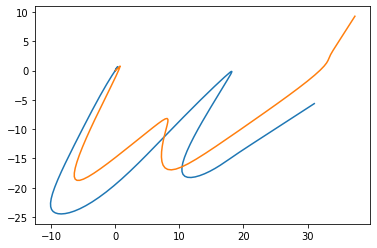

                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.0320      0.0738     0.0261
2  Gaussian SVM, C=100, gamma=auto       0.0000      0.0692     0.0247
3  Poly kernel SVM, C=10, deg=auto       0.0138      0.0892     0.0282
4                    Decision Tree       0.0000      0.1005     0.0294
5     RandomForestClassifier, n=50       0.0000      0.1113     0.0308
6                              KNN       0.0760      0.1172     0.0283
7              Logistic Regression       0.0472      0.0808     0.0294
pairs = 17, 9
total time = 149.82584142684937


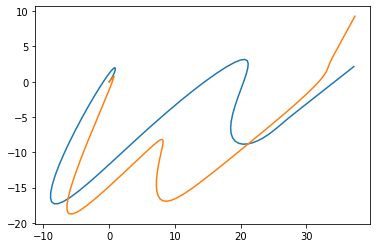

                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.0802      0.1379     0.0423
2  Gaussian SVM, C=100, gamma=auto       0.0001      0.1532     0.0460
3  Poly kernel SVM, C=10, deg=auto       0.0203      0.1597     0.0463
4                    Decision Tree       0.0000      0.1932     0.0461
5     RandomForestClassifier, n=50       0.0000      0.1800     0.0389
6                              KNN       0.1008      0.2104     0.0506
7              Logistic Regression       0.0861      0.1374     0.0397
pairs = 15, 9


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


total time = 144.55103826522827


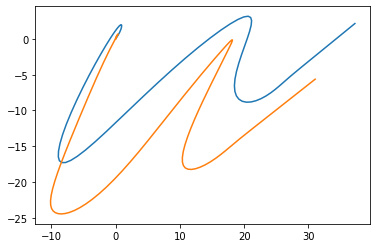

                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.0075      0.0572     0.0209
2  Gaussian SVM, C=100, gamma=auto       0.0000      0.0471     0.0253
3  Poly kernel SVM, C=10, deg=auto       0.0002      0.0620     0.0294
4                    Decision Tree       0.0000      0.0724     0.0249
5     RandomForestClassifier, n=50       0.0000      0.0846     0.0302
6                              KNN       0.0651      0.1073     0.0304
7              Logistic Regression       0.0165      0.0587     0.0264
pairs = 7, 1


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


total time = 146.9605896472931


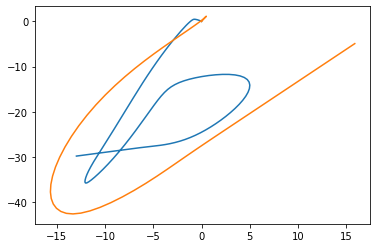

                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.0000      0.0300     0.0145
2  Gaussian SVM, C=100, gamma=auto       0.0000      0.0173     0.0124
3  Poly kernel SVM, C=10, deg=auto       0.0004      0.0254     0.0176
4                    Decision Tree       0.0000      0.0525     0.0275
5     RandomForestClassifier, n=50       0.0000      0.0538     0.0237
6                              KNN       0.0224      0.0408     0.0243
7              Logistic Regression       0.0078      0.0288     0.0138
pairs = 10, 2


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

total time = 149.4512333869934


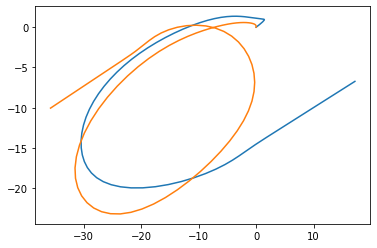

                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.0000      0.0233     0.0197
2  Gaussian SVM, C=100, gamma=auto       0.0000      0.0128     0.0115
3  Poly kernel SVM, C=10, deg=auto       0.0007      0.0223     0.0123
4                    Decision Tree       0.0000      0.0333     0.0229
5     RandomForestClassifier, n=50       0.0000      0.0333     0.0237
6                              KNN       0.0231      0.0491     0.0249
7              Logistic Regression       0.0002      0.0142     0.0138
mean errors: [0.0644, 0.0599, 0.0717, 0.0904, 0.0926, 0.105, 0.064]
std errors: [0.0247, 0.024, 0.0268, 0.0302, 0.0295, 0.0317, 0.0246]


In [ ]:
errors_v_Q = []
stds_v_Q = []

for i in range(len(pairs)):
    n, m = pairs[i]
    print("pairs =", f"{m},", n)

    classifs = binaryClassificationAverageMajority(data[m], data[n], Q_size=20, epoch=50, 
                                        num_trials_maj=11, classifiers=clff, 
                                        version='unsigned', test_size=0.3)
    A = classifs.classification_v_Q()

    plt.plot(data[n][0][:,0], data[n][0][:,1])
    plt.plot(data[m][0][:,0], data[m][0][:,1])
    plt.show()

    errors_v_Q.append(A[2])
    stds_v_Q.append(A[3])
    print(A[0])
    print("=========================================================================")

print(colored(f"mean errors: {list(np.round(np.mean(errors_v_Q,0), decimals=4))}", 'yellow'))
print(colored(f"std errors: {list(np.round(np.mean(stds_v_Q,0), decimals=4))}", 'magenta'))

### Rand $v_Q$ with epoch=50 and num_trials_maj=1

pairs = 17, 15
total time = 15.130184650421143


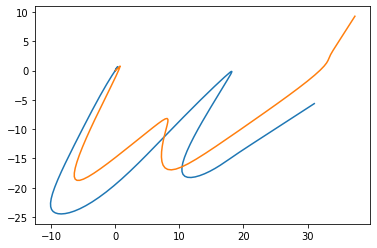

                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.0522      0.1064     0.0395
2  Gaussian SVM, C=100, gamma=auto       0.0000      0.0885     0.0366
3  Poly kernel SVM, C=10, deg=auto       0.0194      0.1049     0.0335
4                    Decision Tree       0.0000      0.1685     0.0531
5     RandomForestClassifier, n=50       0.0001      0.1141     0.0428
6                              KNN       0.0875      0.1218     0.0387
7              Logistic Regression       0.0589      0.0944     0.0341
pairs = 17, 9
total time = 15.162692070007324


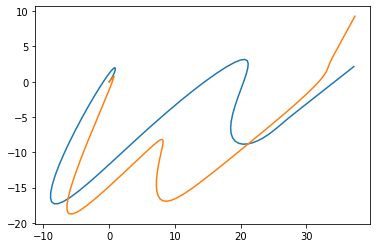

                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.1415      0.1945     0.0522
2  Gaussian SVM, C=100, gamma=auto       0.0028      0.2177     0.0579
3  Poly kernel SVM, C=10, deg=auto       0.0465      0.2197     0.0612
4                    Decision Tree       0.0000      0.2860     0.0683
5     RandomForestClassifier, n=50       0.0002      0.2169     0.0519
6                              KNN       0.1521      0.2408     0.0642
7              Logistic Regression       0.1418      0.1925     0.0519
pairs = 15, 9
total time = 14.318326473236084


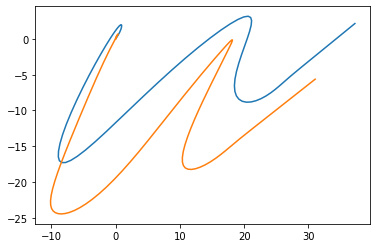

                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.0304      0.0954     0.0383
2  Gaussian SVM, C=100, gamma=auto       0.0001      0.0653     0.0351
3  Poly kernel SVM, C=10, deg=auto       0.0055      0.0899     0.0389
4                    Decision Tree       0.0000      0.1491     0.0459
5     RandomForestClassifier, n=50       0.0000      0.0967     0.0393
6                              KNN       0.0852      0.1215     0.0439
7              Logistic Regression       0.0405      0.0835     0.0393
pairs = 7, 1
total time = 14.8722083568573


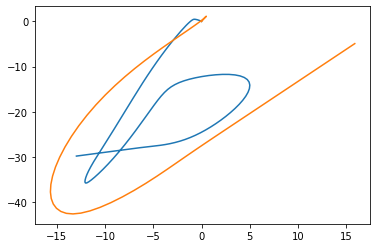

                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.0047      0.0635     0.0264
2  Gaussian SVM, C=100, gamma=auto       0.0000      0.0206     0.0137
3  Poly kernel SVM, C=10, deg=auto       0.0049      0.0427     0.0209
4                    Decision Tree       0.0000      0.0954     0.0322
5     RandomForestClassifier, n=50       0.0001      0.0662     0.0257
6                              KNN       0.0360      0.0473     0.0214
7              Logistic Regression       0.0175      0.0402     0.0199
pairs = 10, 2
total time = 14.502208471298218


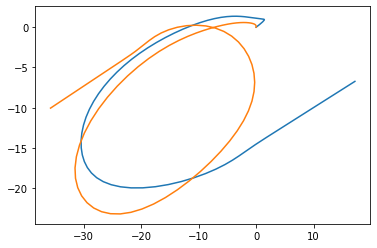

                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.0026      0.0702     0.0439
2  Gaussian SVM, C=100, gamma=auto       0.0000      0.0295     0.0225
3  Poly kernel SVM, C=10, deg=auto       0.0029      0.0556     0.0317
4                    Decision Tree       0.0000      0.1063     0.0442
5     RandomForestClassifier, n=50       0.0001      0.0586     0.0347
6                              KNN       0.0418      0.0753     0.0358
7              Logistic Regression       0.0079      0.0407     0.0335
mean errors: [0.106, 0.0843, 0.1026, 0.161, 0.1105, 0.1213, 0.0903]
std errors: [0.0401, 0.0332, 0.0372, 0.0488, 0.0389, 0.0408, 0.0357]


In [ ]:
errors_v_Q_ave = []
stds_v_Q_ave = []

for i in range(len(pairs)):
    n, m = pairs[i]
    print("pairs =", f"{m},", n)

    classifs = binaryClassificationAverageMajority(data[m], data[n], Q_size=20, epoch=50, 
                                        num_trials_maj=1, classifiers=clff, 
                                        version='unsigned', sigma=1, test_size=0.3)
    A = classifs.classification_v_Q()

    plt.plot(data[n][0][:,0], data[n][0][:,1])
    plt.plot(data[m][0][:,0], data[m][0][:,1])
    plt.show()

    errors_v_Q_ave.append(A[2])
    stds_v_Q_ave.append(A[3])
    print(A[0])
    print("=========================================================================")

print(colored(f"mean errors: {list(np.round(np.mean(errors_v_Q_ave,0), decimals=4))}", 'yellow'))
print(colored(f"std errors: {list(np.round(np.mean(stds_v_Q_ave,0), decimals=4))}", 'magenta'))

## Classification with the feature function  $v_q^{\varsigma}(\gamma)$ and 20 random landmarks and $\varsigma=100$

### Boost($v_Q^{\varsigma}$) with epoch=50 and num_trials_maj=11

pairs = 17, 15
total time = 199.7319450378418


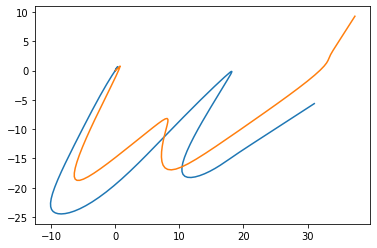

                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.0680      0.0992     0.0320
2  Gaussian SVM, C=100, gamma=auto       0.0000      0.0669     0.0235
3  Poly kernel SVM, C=10, deg=auto       0.0116      0.0821     0.0265
4                    Decision Tree       0.0000      0.0944     0.0291
5     RandomForestClassifier, n=50       0.0000      0.0990     0.0331
6                              KNN       0.0690      0.1008     0.0280
7              Logistic Regression       0.1507      0.1579     0.0391
pairs = 17, 9
total time = 198.37621331214905


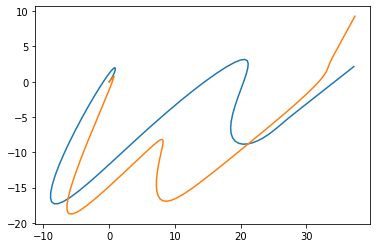

                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.0953      0.1410     0.0376
2  Gaussian SVM, C=100, gamma=auto       0.0002      0.1244     0.0373
3  Poly kernel SVM, C=10, deg=auto       0.0455      0.1831     0.0469
4                    Decision Tree       0.0000      0.1701     0.0474
5     RandomForestClassifier, n=50       0.0000      0.1629     0.0433
6                              KNN       0.1080      0.2005     0.0511
7              Logistic Regression       0.2782      0.3026     0.0453
pairs = 15, 9
total time = 206.61131405830383


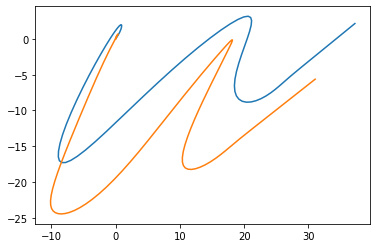

                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.0143      0.0278     0.0189
2  Gaussian SVM, C=100, gamma=auto       0.0000      0.0246     0.0153
3  Poly kernel SVM, C=10, deg=auto       0.0053      0.0334     0.0187
4                    Decision Tree       0.0000      0.0504     0.0274
5     RandomForestClassifier, n=50       0.0000      0.0468     0.0251
6                              KNN       0.0384      0.0587     0.0241
7              Logistic Regression       0.1398      0.1499     0.0464
pairs = 7, 1
total time = 195.79664945602417


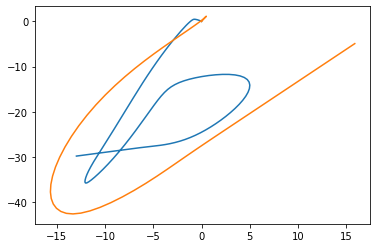

                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.0000      0.0017     0.0044
2  Gaussian SVM, C=100, gamma=auto       0.0000      0.0000     0.0000
3  Poly kernel SVM, C=10, deg=auto       0.0000      0.0002     0.0015
4                    Decision Tree       0.0000      0.0021     0.0055
5     RandomForestClassifier, n=50       0.0000      0.0012     0.0045
6                              KNN       0.0012      0.0017     0.0038
7              Logistic Regression       0.0096      0.0119     0.0106
pairs = 10, 2
total time = 191.66138768196106


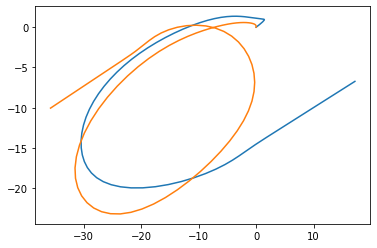

                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.0065      0.0195     0.0134
2  Gaussian SVM, C=100, gamma=auto       0.0000      0.0193     0.0155
3  Poly kernel SVM, C=10, deg=auto       0.0078      0.0381     0.0239
4                    Decision Tree       0.0000      0.0344     0.0176
5     RandomForestClassifier, n=50       0.0000      0.0426     0.0226
6                              KNN       0.0410      0.0684     0.0285
7              Logistic Regression       0.1325      0.1284     0.0441
mean errors: [0.0579, 0.047, 0.0674, 0.0703, 0.0705, 0.086, 0.1501]
std errors: [0.0213, 0.0183, 0.0235, 0.0254, 0.0257, 0.0271, 0.0371]


In [ ]:
errors_v_Q_sigma_ave_maj = []
stds_v_Q_sigma_ave_maj = []

for i in range(len(pairs)):
    n, m = pairs[i]
    print("pairs =", f"{m},", n)

    classifs = binaryClassificationAverageMajority(data[m], data[n], Q_size=20, epoch=50, 
                                        num_trials_maj=11, classifiers=clff, 
                                        version='signed', sigma=100, test_size=0.3)
    A = classifs.classification_v_Q()

    plt.plot(data[n][0][:,0], data[n][0][:,1])
    plt.plot(data[m][0][:,0], data[m][0][:,1])
    plt.show()

    errors_v_Q_sigma_ave_maj.append(A[2])
    stds_v_Q_sigma_ave_maj.append(A[3])
    print(A[0])
    print("=========================================================================")

print(colored(f"mean errors: {list(np.round(np.mean(errors_v_Q_sigma_ave_maj,0), decimals=4))}", 'yellow'))
print(colored(f"std errors: {list(np.round(np.mean(stds_v_Q_sigma_ave_maj,0), decimals=4))}", 'magenta'))

### Rand $v_Q^{\varsigma}$ with epoch=50 and num_trials_maj=1

pairs = 17, 15
total time = 19.591286420822144


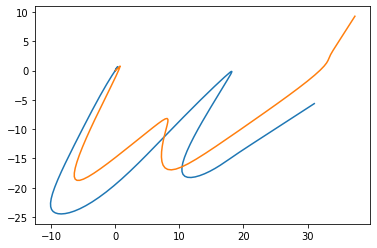

                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.0817      0.1295     0.0413
2  Gaussian SVM, C=100, gamma=auto       0.0007      0.1174     0.0485
3  Poly kernel SVM, C=10, deg=auto       0.0224      0.1346     0.0454
4                    Decision Tree       0.0000      0.1664     0.0411
5     RandomForestClassifier, n=50       0.0003      0.1208     0.0394
6                              KNN       0.0898      0.1310     0.0355
7              Logistic Regression       0.1769      0.2036     0.0570
pairs = 17, 9
total time = 19.444889068603516


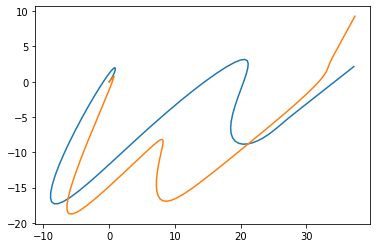

                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.1693      0.2255     0.0739
2  Gaussian SVM, C=100, gamma=auto       0.0046      0.2091     0.0549
3  Poly kernel SVM, C=10, deg=auto       0.0865      0.2504     0.0631
4                    Decision Tree       0.0000      0.2748     0.0578
5     RandomForestClassifier, n=50       0.0000      0.2005     0.0475
6                              KNN       0.1683      0.2634     0.0605
7              Logistic Regression       0.3083      0.3345     0.0511
pairs = 15, 9
total time = 19.79732871055603


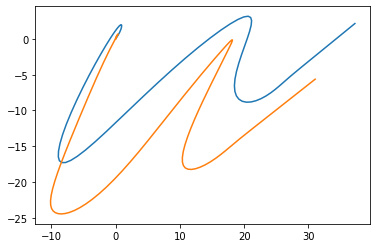

                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.0341      0.0565     0.0340
2  Gaussian SVM, C=100, gamma=auto       0.0007      0.0519     0.0309
3  Poly kernel SVM, C=10, deg=auto       0.0137      0.0663     0.0379
4                    Decision Tree       0.0000      0.1286     0.0516
5     RandomForestClassifier, n=50       0.0001      0.0699     0.0349
6                              KNN       0.0635      0.0838     0.0354
7              Logistic Regression       0.1589      0.1633     0.0503
pairs = 7, 1
total time = 21.410815715789795


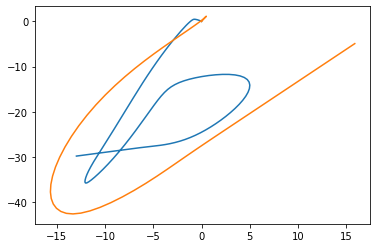

                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.0002      0.0058     0.0086
2  Gaussian SVM, C=100, gamma=auto       0.0000      0.0023     0.0048
3  Poly kernel SVM, C=10, deg=auto       0.0000      0.0040     0.0059
4                    Decision Tree       0.0000      0.0115     0.0125
5     RandomForestClassifier, n=50       0.0000      0.0054     0.0070
6                              KNN       0.0045      0.0062     0.0075
7              Logistic Regression       0.0220      0.0240     0.0217
pairs = 10, 2
total time = 19.76755952835083


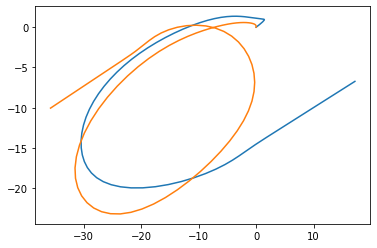

                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.0268      0.0530     0.0279
2  Gaussian SVM, C=100, gamma=auto       0.0000      0.0493     0.0272
3  Poly kernel SVM, C=10, deg=auto       0.0165      0.0835     0.0309
4                    Decision Tree       0.0000      0.1037     0.0362
5     RandomForestClassifier, n=50       0.0000      0.0705     0.0265
6                              KNN       0.0630      0.0944     0.0368
7              Logistic Regression       0.1471      0.1507     0.0475
mean errors: [0.0941, 0.086, 0.1078, 0.137, 0.0934, 0.1158, 0.1752]
std errors: [0.0371, 0.0333, 0.0366, 0.0398, 0.031, 0.0351, 0.0455]


In [ ]:
errors_v_Q_sigma_ave = []
stds_v_Q_sigma_ave = []

for i in range(len(pairs)):
    n, m = pairs[i]
    print("pairs =", f"{m},", n)

    classifs = binaryClassificationAverageMajority(data[m], data[n], Q_size=20, epoch=50, 
                                        num_trials_maj=1, classifiers=clff, 
                                        version='signed', sigma=100, test_size=0.3)
    A = classifs.classification_v_Q()

    plt.plot(data[n][0][:,0], data[n][0][:,1])
    plt.plot(data[m][0][:,0], data[m][0][:,1])
    plt.show()

    errors_v_Q_sigma_ave.append(A[2])
    stds_v_Q_sigma_ave.append(A[3])
    print(A[0])
    print("=========================================================================")

print(colored(f"mean errors: {list(np.round(np.mean(errors_v_Q_sigma_ave,0), decimals=4))}", 'yellow'))
print(colored(f"std errors: {list(np.round(np.mean(stds_v_Q_sigma_ave,0), decimals=4))}", 'magenta'))

## Classification with the feature function  $v_Q^{\exp}$ and 20 random landmarks

### Boost($v_Q^{\exp})$ with epoch=50 and num_maj=11

pairs = 17, 15
total time = 136.61377334594727


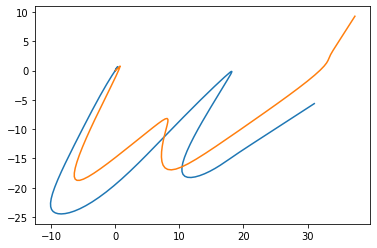

                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.0572      0.0882     0.0278
2  Gaussian SVM, C=100, gamma=auto       0.0000      0.0687     0.0237
3  Poly kernel SVM, C=10, deg=auto       0.0151      0.0836     0.0267
4                    Decision Tree       0.0000      0.1008     0.0258
5     RandomForestClassifier, n=50       0.0000      0.1051     0.0276
6                              KNN       0.0665      0.1067     0.0351
7              Logistic Regression       0.1010      0.1156     0.0344
pairs = 17, 9
total time = 138.91755032539368


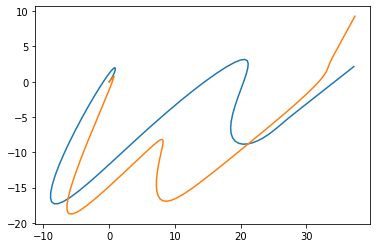

                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.1219      0.1919     0.0503
2  Gaussian SVM, C=100, gamma=auto       0.0022      0.1855     0.0471
3  Poly kernel SVM, C=10, deg=auto       0.0330      0.1797     0.0479
4                    Decision Tree       0.0000      0.1977     0.0398
5     RandomForestClassifier, n=50       0.0000      0.1727     0.0398
6                              KNN       0.0826      0.1938     0.0411
7              Logistic Regression       0.1569      0.2104     0.0563
pairs = 15, 9
total time = 135.43609237670898


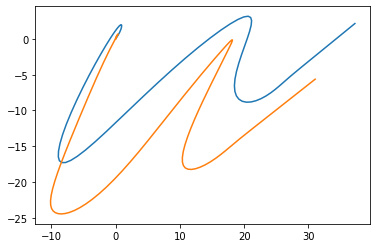

                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.0981      0.1347     0.0298
2  Gaussian SVM, C=100, gamma=auto       0.0000      0.1111     0.0289
3  Poly kernel SVM, C=10, deg=auto       0.0170      0.1372     0.0342
4                    Decision Tree       0.0000      0.0772     0.0292
5     RandomForestClassifier, n=50       0.0000      0.0848     0.0289
6                              KNN       0.0844      0.1420     0.0337
7              Logistic Regression       0.1338      0.1544     0.0347
pairs = 7, 1
total time = 142.31539463996887


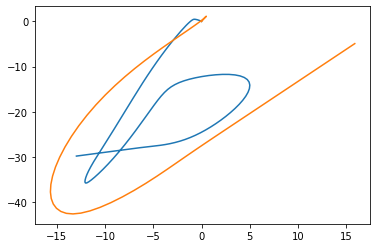

                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.0132      0.0308     0.0174
2  Gaussian SVM, C=100, gamma=auto       0.0000      0.0125     0.0110
3  Poly kernel SVM, C=10, deg=auto       0.0031      0.0323     0.0191
4                    Decision Tree       0.0000      0.0477     0.0210
5     RandomForestClassifier, n=50       0.0000      0.0496     0.0214
6                              KNN       0.0276      0.0429     0.0179
7              Logistic Regression       0.0648      0.0812     0.0225
pairs = 10, 2
total time = 134.87601828575134


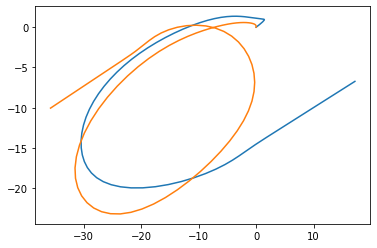

                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.0006      0.0207     0.0151
2  Gaussian SVM, C=100, gamma=auto       0.0000      0.0098     0.0094
3  Poly kernel SVM, C=10, deg=auto       0.0000      0.0242     0.0169
4                    Decision Tree       0.0000      0.0267     0.0208
5     RandomForestClassifier, n=50       0.0000      0.0298     0.0168
6                              KNN       0.0141      0.0272     0.0165
7              Logistic Regression       0.0252      0.0379     0.0190
mean errors: [0.0933, 0.0775, 0.0914, 0.09, 0.0884, 0.1025, 0.1199]
std errors: [0.0281, 0.024, 0.029, 0.0273, 0.0269, 0.0289, 0.0334]


In [ ]:
errors_v_Q_mu = []
stds_v_Q_mu = []

for i in range(len(pairs)):
    n, m = pairs[i]
    print("pairs =", f"{m},", n)

    classifs = binaryClassificationAverageMajority(data[m], data[n], Q_size=20, epoch=50, 
                                        num_trials_maj=11, classifiers=clff, test_size=0.3)
    A = classifs.classification_v_Q_mu()

    plt.plot(data[n][0][:,0], data[n][0][:,1])
    plt.plot(data[m][0][:,0], data[m][0][:,1])
    plt.show()

    errors_v_Q_mu.append(A[2])
    stds_v_Q_mu.append(A[3])
    print(A[0])
    print("=========================================================================")

print(colored(f"mean errors: {list(np.round(np.mean(errors_v_Q_mu,0), decimals=4))}", 'yellow'))
print(colored(f"std errors: {list(np.round(np.mean(stds_v_Q_mu,0), decimals=4))}", 'magenta'))

### Rand $v_Q^{\exp}$ with epoch=50 and num_maj=1

pairs = 17, 15
total time = 13.748543739318848


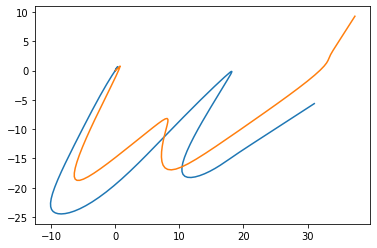

                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.0822      0.1254     0.0409
2  Gaussian SVM, C=100, gamma=auto       0.0019      0.1413     0.0470
3  Poly kernel SVM, C=10, deg=auto       0.0337      0.1262     0.0433
4                    Decision Tree       0.0000      0.1654     0.0552
5     RandomForestClassifier, n=50       0.0001      0.1190     0.0375
6                              KNN       0.0983      0.1405     0.0498
7              Logistic Regression       0.1318      0.1444     0.0451
pairs = 17, 9
total time = 13.790015697479248


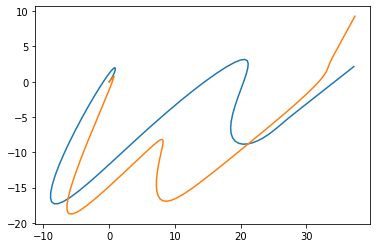

                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.2158      0.2704     0.0676
2  Gaussian SVM, C=100, gamma=auto       0.0201      0.2855     0.0629
3  Poly kernel SVM, C=10, deg=auto       0.1065      0.2855     0.0607
4                    Decision Tree       0.0000      0.3039     0.0616
5     RandomForestClassifier, n=50       0.0001      0.2449     0.0556
6                              KNN       0.1869      0.2844     0.0638
7              Logistic Regression       0.2507      0.2883     0.0685
pairs = 15, 9
total time = 14.229240417480469


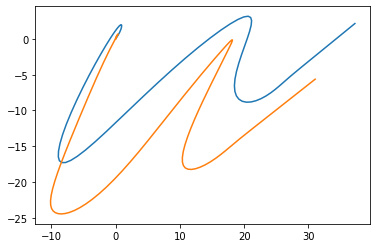

                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.1591      0.2132     0.0642
2  Gaussian SVM, C=100, gamma=auto       0.0266      0.2132     0.0634
3  Poly kernel SVM, C=10, deg=auto       0.0944      0.2332     0.0717
4                    Decision Tree       0.0000      0.1767     0.0718
5     RandomForestClassifier, n=50       0.0001      0.1268     0.0589
6                              KNN       0.1508      0.2197     0.0658
7              Logistic Regression       0.1858      0.2230     0.0644
pairs = 7, 1
total time = 14.58183217048645


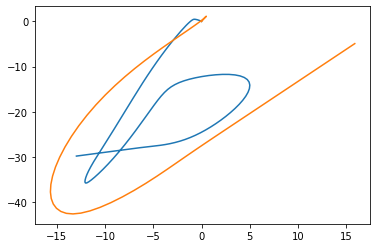

                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.0182      0.0450     0.0231
2  Gaussian SVM, C=100, gamma=auto       0.0001      0.0304     0.0200
3  Poly kernel SVM, C=10, deg=auto       0.0119      0.0496     0.0289
4                    Decision Tree       0.0000      0.1127     0.0409
5     RandomForestClassifier, n=50       0.0001      0.0696     0.0361
6                              KNN       0.0428      0.0596     0.0280
7              Logistic Regression       0.0795      0.0888     0.0336
pairs = 10, 2
total time = 13.775493621826172


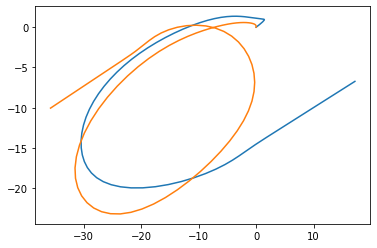

                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.0229      0.0663     0.0322
2  Gaussian SVM, C=100, gamma=auto       0.0001      0.0442     0.0256
3  Poly kernel SVM, C=10, deg=auto       0.0098      0.0723     0.0317
4                    Decision Tree       0.0000      0.1079     0.0386
5     RandomForestClassifier, n=50       0.0001      0.0581     0.0292
6                              KNN       0.0490      0.0765     0.0369
7              Logistic Regression       0.0602      0.0633     0.0316
mean errors: [0.144, 0.1429, 0.1533, 0.1733, 0.1237, 0.1562, 0.1615]
std errors: [0.0456, 0.0438, 0.0473, 0.0536, 0.0435, 0.0489, 0.0487]


In [ ]:
errors_v_Q_mu_ave = []
stds_v_Q_mu_ave = []

for i in range(len(pairs)):
    n, m = pairs[i]
    print("pairs =", f"{m},", n)

    classifs = binaryClassificationAverageMajority(data[m], data[n], Q_size=20, epoch=50, 
                                        num_trials_maj=1, classifiers=clff, test_size=0.3)
    A = classifs.classification_v_Q_mu()

    plt.plot(data[n][0][:,0], data[n][0][:,1])
    plt.plot(data[m][0][:,0], data[m][0][:,1])
    plt.show()

    errors_v_Q_mu_ave.append(A[2])
    stds_v_Q_mu_ave.append(A[3])
    print(A[0])
    print("=========================================================================")

print(colored(f"mean errors: {list(np.round(np.mean(errors_v_Q_mu_ave,0), decimals=4))}", 'yellow'))
print(colored(f"std errors: {list(np.round(np.mean(stds_v_Q_mu_ave,0), decimals=4))}", 'magenta'))

# Classification based on endpoints with epoch=50

pairs = 17, 15
total time = 6.1263206005096436
Number of trials = 50


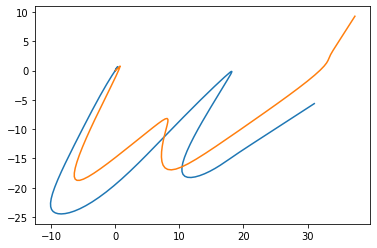

                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.2027      0.2113     0.0444
2  Gaussian SVM, C=100, gamma=auto       0.1627      0.1969     0.0384
3  Poly kernel SVM, C=10, deg=auto       0.2442      0.2533     0.0416
4                    Decision Tree       0.0000      0.2421     0.0466
5     RandomForestClassifier, n=50       0.0011      0.2159     0.0383
6                              KNN       0.1478      0.2241     0.0393
7              Logistic Regression       0.2025      0.2108     0.0427
pairs = 17, 9
total time = 5.961443901062012
Number of trials = 50


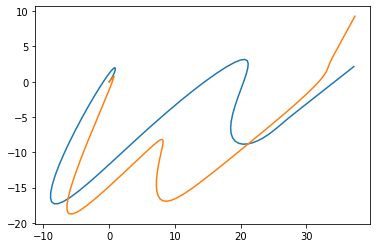

                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.3587      0.3766     0.0402
2  Gaussian SVM, C=100, gamma=auto       0.3098      0.3644     0.0417
3  Poly kernel SVM, C=10, deg=auto       0.3846      0.4068     0.0381
4                    Decision Tree       0.0000      0.4361     0.0435
5     RandomForestClassifier, n=50       0.0010      0.4221     0.0377
6                              KNN       0.2626      0.4182     0.0421
7              Logistic Regression       0.3637      0.3795     0.0431
pairs = 15, 9
total time = 5.987739086151123
Number of trials = 50


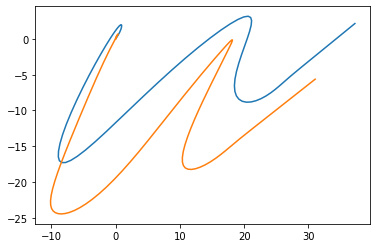

                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.3637      0.3625     0.0415
2  Gaussian SVM, C=100, gamma=auto       0.1957      0.2365     0.0330
3  Poly kernel SVM, C=10, deg=auto       0.3947      0.4144     0.0697
4                    Decision Tree       0.0000      0.2719     0.0442
5     RandomForestClassifier, n=50       0.0012      0.2375     0.0360
6                              KNN       0.1735      0.2597     0.0357
7              Logistic Regression       0.3629      0.3608     0.0430
pairs = 7, 1
total time = 5.491094350814819
Number of trials = 50


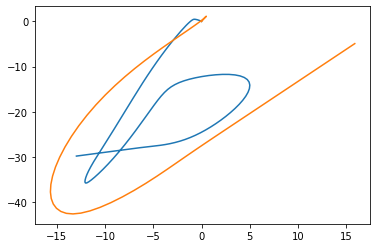

                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.0125      0.0169     0.0116
2  Gaussian SVM, C=100, gamma=auto       0.0086      0.0137     0.0126
3  Poly kernel SVM, C=10, deg=auto       0.0142      0.0196     0.0111
4                    Decision Tree       0.0000      0.0112     0.0097
5     RandomForestClassifier, n=50       0.0000      0.0123     0.0101
6                              KNN       0.0111      0.0142     0.0114
7              Logistic Regression       0.0119      0.0165     0.0118
pairs = 10, 2
total time = 5.80356502532959
Number of trials = 50


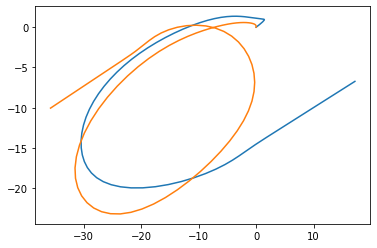

                        Classifier  Train Error  Test Error  Std Error
1          SVM, LinearSVC, C = 100       0.1756      0.1781     0.0293
2  Gaussian SVM, C=100, gamma=auto       0.0739      0.0953     0.0229
3  Poly kernel SVM, C=10, deg=auto       0.2687      0.2786     0.0291
4                    Decision Tree       0.0000      0.1070     0.0309
5     RandomForestClassifier, n=50       0.0007      0.0984     0.0218
6                              KNN       0.0821      0.1144     0.0274
7              Logistic Regression       0.1804      0.1823     0.0280
mean errors: [0.2291, 0.1814, 0.2745, 0.2137, 0.1972, 0.2061, 0.23]
std errors: [0.0334, 0.0297, 0.0379, 0.035, 0.0288, 0.0312, 0.0337]


In [ ]:
errors_endpoint = []
stds_endpoint = []

for i in range(len(pairs)):
    n, m = pairs[i]
    print("pairs =", f"{m},", n)

    classifs = binaryClassificationAverageMajority(data[m], data[n], 
                                            Q_size=1, epoch=50, num_trials_maj=1, 
                                            classifiers=clff, test_size=0.3)
    A = classifs.endpoint_classification()

    plt.plot(data[n][0][:,0], data[n][0][:,1])
    plt.plot(data[m][0][:,0], data[m][0][:,1])
    plt.show()

    errors_endpoint.append(A[2])
    stds_endpoint.append(A[3])
    print(A[0])
    print("=========================================================================")

print(colored(f"mean errors: {list(np.round(np.mean(errors_endpoint,0), decimals=4))}", 'yellow'))
print(colored(f"std errors: {list(np.round(np.mean(stds_endpoint,0), decimals=4))}", 'magenta'))

# Classification with perceptron-like algorithm with 20 landmarks

In [ ]:
# to import Perceptron_Like_Algo_Class from my computer
from google.colab import files
files.upload()

import Perceptron_Like_Algo_Class
from Perceptron_Like_Algo_Class import classification

Saving Perceptron_Like_Algo_Class.py to Perceptron_Like_Algo_Class.py


## Boost(MD $v_Q^{\exp}$) with epoch=50, majority=11 and init_num=3

pairs = 15, 17
total time = 2686.1497349739075


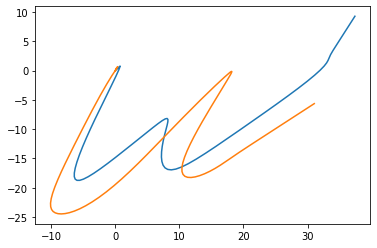

               Classifier  Train Error  Test Error  Std Error
1  SVM, Linear SVC, C=100       0.0162       0.061     0.0218
pairs = 9, 17
total time = 2778.53843665123


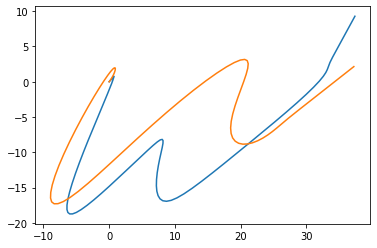

               Classifier  Train Error  Test Error  Std Error
1  SVM, Linear SVC, C=100       0.0325      0.1125     0.0417
pairs = 9, 15
total time = 2921.04101395607


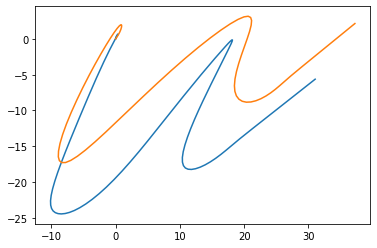

               Classifier  Train Error  Test Error  Std Error
1  SVM, Linear SVC, C=100       0.0107      0.0646     0.0238
pairs = 1, 7
total time = 2901.4079575538635


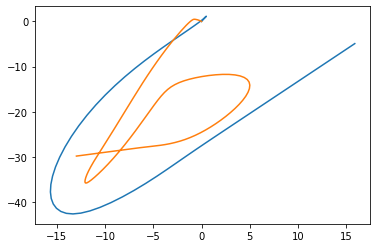

               Classifier  Train Error  Test Error  Std Error
1  SVM, Linear SVC, C=100       0.0041      0.0244     0.0134
pairs = 2, 10
total time = 2660.749302148819


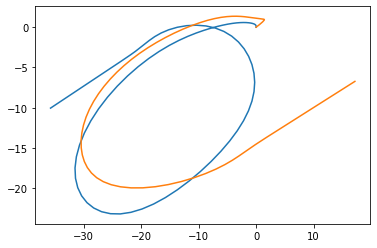

               Classifier  Train Error  Test Error  Std Error
1  SVM, Linear SVC, C=100          0.0      0.0156     0.0146
Mistake deriven LSVM test errors for 5 pairs: 
 [[0.061 ]
 [0.1125]
 [0.0646]
 [0.0244]
 [0.0156]]
Mistake deriven LSVM stds of test error for 5 pairs: 
 [[0.0218]
 [0.0417]
 [0.0238]
 [0.0134]
 [0.0146]]
Mistake deriven LSVM average test error on 5 pairs: 
 [0.0556]
Mistake deriven LSVM average stds of test error on 5 pairs: 
 [0.0231]


In [ ]:
perc_LSVM_errors = []
perc_LSVM_stds = []

for i in range(len(pairs)):
    m, n = pairs[i]
    print("pairs =", f"{m},", n)

    classif = classification(data[n], data[m], Q_size=20, model='LSVM', 
                                C=100, gamma=10, classifiers=[], epoch=50, maj_num=11, 
                                init_iter=3, std_coeff=1, test_size=0.3, n_neighbors=5, 
                                n_estimators=50)

    A = classif.classification_Q()
    plt.plot(data[n][0][:,0], data[n][0][:,1])
    plt.plot(data[m][0][:,0], data[m][0][:,1])
    plt.show()

    perc_LSVM_errors.append(np.round(A[3], decimals=4)) 
    perc_LSVM_stds.append(np.round(A[4], decimals=4))
    
    print(A[0])
    print("=============================================================")
    
print(colored(f'Mistake deriven LSVM test errors for 5 pairs: \n {np.array(perc_LSVM_errors)}', 'green'))
print(colored(f'Mistake deriven LSVM stds of test error for 5 pairs: \n {np.array(perc_LSVM_stds)}', 'magenta'))

print(colored(f'Mistake deriven LSVM average test error on 5 pairs: \n {list(np.round(np.mean(perc_LSVM_errors, 0), decimals=4))}', 'yellow'))
print(colored(f'Mistake deriven LSVM average stds of test error on 5 pairs: \n {list(np.round(np.mean(perc_LSVM_stds, 0), decimals=4))}', 'blue'))

np.savetxt('/content/gdrive/My Drive/Research/Characters/test errors and stds (Perceptron-like)/LSVM-error.csv', 
            perc_LSVM_errors, delimiter=',')
np.savetxt('/content/gdrive/My Drive/Research/Characters/test errors and stds (Perceptron-like)/LSVM-std.csv', 
            perc_LSVM_stds, delimiter=',')

np.savetxt('/content/gdrive/My Drive/Research/Characters/test errors and stds (Perceptron-like)/LSVM-error-ave.csv', 
            np.round(np.mean(perc_LSVM_errors, 0), decimals=4), delimiter=',')
np.savetxt('/content/gdrive/My Drive/Research/Characters/test errors and stds (Perceptron-like)/LSVM-std-ave.csv', 
            np.round(np.mean(perc_LSVM_stds, 0), decimals=4), delimiter=',')


In [ ]:
#pd.read_csv('/content/gdrive/My Drive/Research/Characters/test errors and stds (Perceptron-like)/LSVM-error-ave.csv', header=None)

pairs = 15, 17
total time = 3169.373363494873


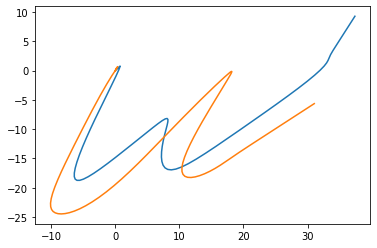

                Classifier  Train Error  Test Error  Std Error
1  GSVM, C=100, gamma=auto          0.0      0.0556     0.0275
pairs = 9, 17
total time = 3109.6312804222107


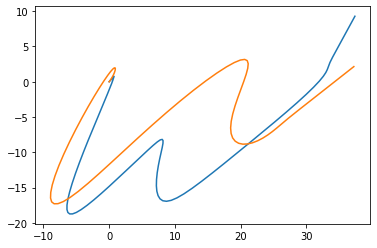

                Classifier  Train Error  Test Error  Std Error
1  GSVM, C=100, gamma=auto          0.0      0.1016     0.0339
pairs = 9, 15
total time = 3409.4716324806213


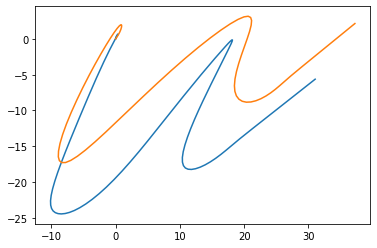

                Classifier  Train Error  Test Error  Std Error
1  GSVM, C=100, gamma=auto          0.0      0.0704     0.0303
pairs = 1, 7
total time = 3274.796526670456


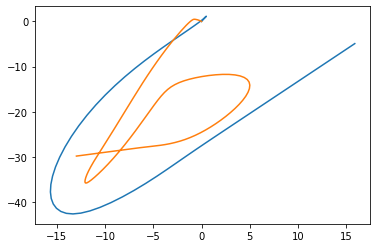

                Classifier  Train Error  Test Error  Std Error
1  GSVM, C=100, gamma=auto          0.0      0.0156     0.0115
pairs = 2, 10
total time = 3127.9666101932526


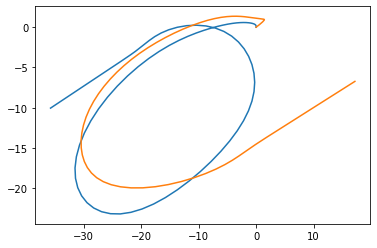

                Classifier  Train Error  Test Error  Std Error
1  GSVM, C=100, gamma=auto          0.0      0.0128     0.0115
Mistake deriven GSVM test errors for 5 pairs: 
 [[0.0556]
 [0.1016]
 [0.0704]
 [0.0156]
 [0.0128]]
Mistake deriven GSVM stds of test error for 5 pairs: 
 [[0.0275]
 [0.0339]
 [0.0303]
 [0.0115]
 [0.0115]]
Mistake deriven GSVM average test error on 5 pairs: 
 [0.0512]
Mistake deriven GSVM average stds of test error on 5 pairs: 
 [0.0229]


In [ ]:
perc_GSVM_errors = []
perc_GSVM_stds = []

for i in range(len(pairs)): 
    m, n = pairs[i]
    print("pairs =", f"{m},", n)

    classif = classification(data[n], data[m], Q_size=20, model='GSVM', 
                                C=100, gamma='auto', classifiers=[], epoch=50, maj_num=11, 
                                init_iter=3, std_coeff=1, test_size=0.3, n_neighbors=5, 
                                n_estimators=50)

    A = classif.classification_Q()
    plt.plot(data[n][0][:,0], data[n][0][:,1])
    plt.plot(data[m][0][:,0], data[m][0][:,1])
    plt.show()

    perc_GSVM_errors.append(np.round(A[3], decimals=4)) 
    perc_GSVM_stds.append(np.round(A[4], decimals=4))
    
    print(A[0])
    print("===========================================================================")
    
print(colored(f'Mistake deriven GSVM test errors for 5 pairs: \n {np.array(perc_GSVM_errors)}', 'green'))
print(colored(f'Mistake deriven GSVM stds of test error for 5 pairs: \n {np.array(perc_GSVM_stds)}', 'magenta'))

print(colored(f'Mistake deriven GSVM average test error on 5 pairs: \n {list(np.round(np.mean(perc_GSVM_errors, 0), decimals=4))}', 'yellow'))
print(colored(f'Mistake deriven GSVM average stds of test error on 5 pairs: \n {list(np.round(np.mean(perc_GSVM_stds, 0), decimals=4))}', 'blue'))

np.savetxt('/content/gdrive/My Drive/Research/Characters/test errors and stds (Perceptron-like)/GSVM-error.csv', 
            perc_GSVM_errors, delimiter=',')
np.savetxt('/content/gdrive/My Drive/Research/Characters/test errors and stds (Perceptron-like)/GSVM-std.csv', 
            perc_GSVM_stds, delimiter=',')

np.savetxt('/content/gdrive/My Drive/Research/Characters/test errors and stds (Perceptron-like)/GSVM-error-ave.csv', 
            np.round(np.mean(perc_GSVM_errors, 0), decimals=4), delimiter=',')
np.savetxt('/content/gdrive/My Drive/Research/Characters/test errors and stds (Perceptron-like)/GSVM-std-ave.csv', 
            np.round(np.mean(perc_GSVM_stds, 0), decimals=4), delimiter=',')


pairs = 15, 17


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklea

total time = 2871.882479429245


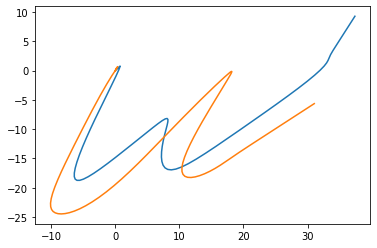

                         Classifier  Train Error  Test Error  Std Error
1  Poly kernel SVM, C=100, deg=auto          0.0      0.0572     0.0232
pairs = 9, 17


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklea

total time = 2938.159146308899


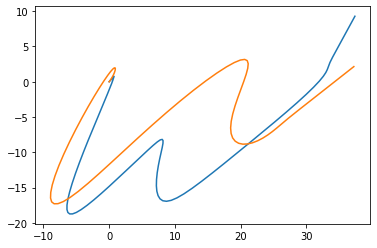

                         Classifier  Train Error  Test Error  Std Error
1  Poly kernel SVM, C=100, deg=auto          0.0      0.1296     0.0415
pairs = 9, 15


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklea

total time = 2915.315373659134


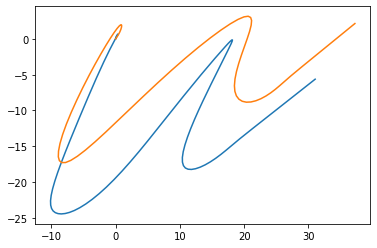

                         Classifier  Train Error  Test Error  Std Error
1  Poly kernel SVM, C=100, deg=auto          0.0      0.0919     0.0339
pairs = 1, 7


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklea

total time = 3126.4886531829834


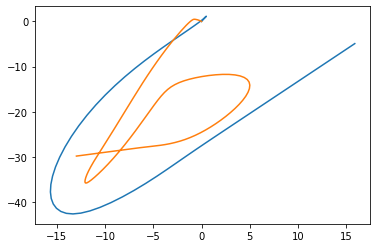

                         Classifier  Train Error  Test Error  Std Error
1  Poly kernel SVM, C=100, deg=auto          0.0      0.0296     0.0152
pairs = 2, 10


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklea

total time = 2853.3596589565277


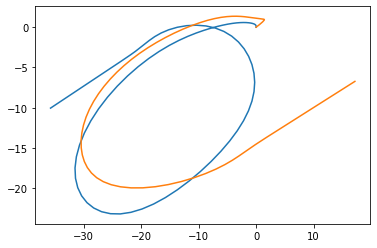

                         Classifier  Train Error  Test Error  Std Error
1  Poly kernel SVM, C=100, deg=auto          0.0      0.0228       0.02
Mistake deriven PSVM test errors for 5 pairs: 
 [[0.0572]
 [0.1296]
 [0.0919]
 [0.0296]
 [0.0228]]
Mistake deriven PSVM stds of test error for 5 pairs: 
 [[0.0232]
 [0.0415]
 [0.0339]
 [0.0152]
 [0.02  ]]
Mistake deriven PSVM average test error on 5 pairs: 
       [0.0662]
Mistake deriven PSVM average stds of test error on 5 pairs: 
       [0.0268]


In [ ]:
perc_PSVM_errors = []
perc_PSVM_stds = []

for i in range(len(pairs)):
    m, n = pairs[i]
    print("pairs =", f"{m},", n)

    classif = classification(data[n], data[m], Q_size=20, model='PSVM', 
                                C=100, gamma=10, classifiers=[], epoch=50, maj_num=11, 
                                init_iter=3, std_coeff=1, test_size=0.3, n_neighbors=5, 
                                n_estimators=50)

    A = classif.classification_Q()
    plt.plot(data[n][0][:,0], data[n][0][:,1])
    plt.plot(data[m][0][:,0], data[m][0][:,1])
    plt.show()

    perc_PSVM_errors.append(np.round(A[3], decimals=4)) 
    perc_PSVM_stds.append(np.round(A[4], decimals=4))
    
    print(A[0])
    print("===========================================================================")
    
print(colored(f'Mistake deriven PSVM test errors for 5 pairs: \n {np.array(perc_PSVM_errors)}', 'green'))
print(colored(f'Mistake deriven PSVM stds of test error for 5 pairs: \n {np.array(perc_PSVM_stds)}', 'magenta'))

print(colored(f'Mistake deriven PSVM average test error on 5 pairs: \n       {list(np.round(np.mean(perc_PSVM_errors, 0), decimals=4))}', 'yellow'))
print(colored(f'Mistake deriven PSVM average stds of test error on 5 pairs: \n       {list(np.round(np.mean(perc_PSVM_stds, 0), decimals=4))}', 'blue'))

np.savetxt('/content/gdrive/My Drive/Research/Characters/test errors and stds (Perceptron-like)/PSVM-error.csv', 
            perc_PSVM_errors, delimiter=',')
np.savetxt('/content/gdrive/My Drive/Research/Characters/test errors and stds (Perceptron-like)/PSVM-std.csv', 
            perc_PSVM_stds, delimiter=',')

np.savetxt('/content/gdrive/My Drive/Research/Characters/test errors and stds (Perceptron-like)/PSVM-error-ave.csv', 
            np.round(np.mean(perc_PSVM_errors, 0), decimals=4), delimiter=',')
np.savetxt('/content/gdrive/My Drive/Research/Characters/test errors and stds (Perceptron-like)/PSVM-std-ave.csv', 
            np.round(np.mean(perc_PSVM_stds, 0), decimals=4), delimiter=',')


pairs = 15, 17
total time = 2770.8510291576385


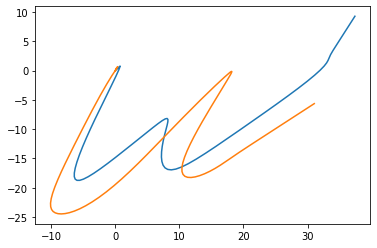

      Classifier  Train Error  Test Error  Std Error
1  Decision Tree          0.0      0.1269     0.0408
pairs = 9, 17
total time = 2719.6685905456543


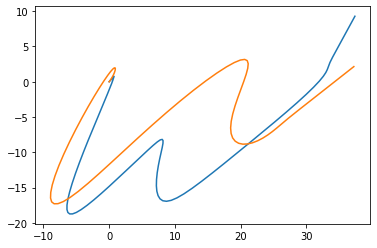

      Classifier  Train Error  Test Error  Std Error
1  Decision Tree          0.0      0.1808     0.0481
pairs = 9, 15
total time = 2824.3250114917755


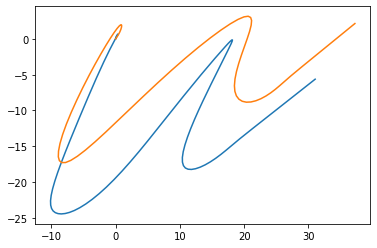

      Classifier  Train Error  Test Error  Std Error
1  Decision Tree          0.0      0.1038     0.0303
pairs = 1, 7
total time = 2945.596851348877


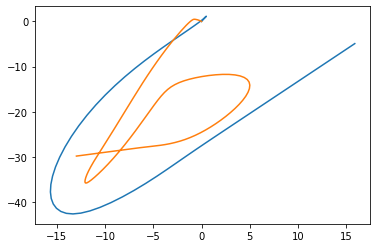

      Classifier  Train Error  Test Error  Std Error
1  Decision Tree          0.0      0.0617     0.0241
pairs = 2, 10
total time = 2682.176580429077


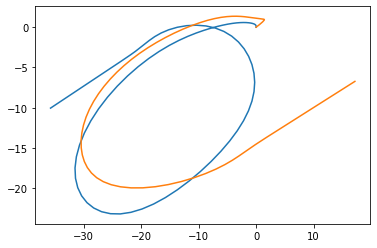

      Classifier  Train Error  Test Error  Std Error
1  Decision Tree          0.0      0.0335     0.0194
Mistake deriven DT test errors for 5 pairs: 
 [[0.1269]
 [0.1808]
 [0.1038]
 [0.0617]
 [0.0335]]
Mistake deriven DT stds of test error for 5 pairs: 
 [[0.0408]
 [0.0481]
 [0.0303]
 [0.0241]
 [0.0194]]
Mistake deriven DT average test error on 5 pairs: 
       [0.1013]
Mistake deriven DT average stds of test error on 5 pairs: 
       [0.0325]


In [ ]:
perc_DT_errors = []
perc_DT_stds = []

for i in range(len(pairs)):
    m, n = pairs[i]
    print("pairs =", f"{m},", n)

    classif = classification(data[n], data[m], Q_size=20, model='DT', 
                                C=100, gamma=10, classifiers=[], epoch=50, maj_num=11, 
                                init_iter=3, std_coeff=1, test_size=0.3, n_neighbors=5, 
                                n_estimators=50)

    A = classif.classification_Q()
    plt.plot(data[n][0][:,0], data[n][0][:,1])
    plt.plot(data[m][0][:,0], data[m][0][:,1])
    plt.show()

    perc_DT_errors.append(np.round(A[3], decimals=4)) 
    perc_DT_stds.append(np.round(A[4], decimals=4))
    
    print(A[0])
    print("===========================================================================")
    
print(colored(f'Mistake deriven DT test errors for 5 pairs: \n {np.array(perc_DT_errors)}', 'green'))
print(colored(f'Mistake deriven DT stds of test error for 5 pairs: \n {np.array(perc_DT_stds)}', 'magenta'))

print(colored(f'Mistake deriven DT average test error on 5 pairs: \n       {list(np.round(np.mean(perc_DT_errors, 0), decimals=4))}', 'yellow'))
print(colored(f'Mistake deriven DT average stds of test error on 5 pairs: \n       {list(np.round(np.mean(perc_DT_stds, 0), decimals=4))}', 'blue'))

np.savetxt('/content/gdrive/My Drive/Research/Characters/test errors and stds (Perceptron-like)/DT-error.csv', 
            perc_DT_errors, delimiter=',')
np.savetxt('/content/gdrive/My Drive/Research/Characters/test errors and stds (Perceptron-like)/DT-std.csv', 
            perc_DT_stds, delimiter=',')

np.savetxt('/content/gdrive/My Drive/Research/Characters/test errors and stds (Perceptron-like)/DT-error-ave.csv', 
            np.round(np.mean(perc_DT_errors, 0), decimals=4), delimiter=',')
np.savetxt('/content/gdrive/My Drive/Research/Characters/test errors and stds (Perceptron-like)/DT-std-ave.csv', 
            np.round(np.mean(perc_DT_stds, 0), decimals=4), delimiter=',')


pairs = 15, 17
total time = 6328.170721530914


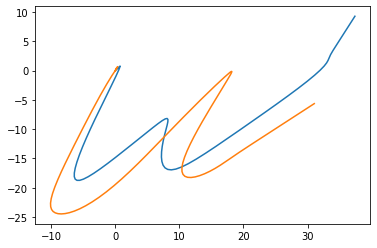

                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50          0.0      0.1069     0.0322
pairs = 9, 17
total time = 6293.541034460068


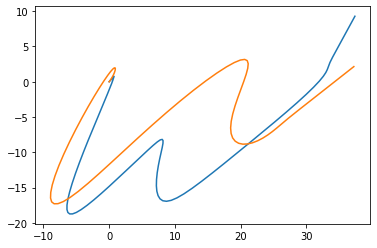

                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50          0.0      0.1179     0.0326
pairs = 9, 15
total time = 6341.206139326096


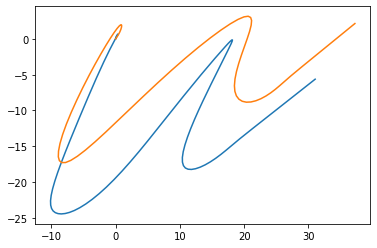

                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50          0.0      0.0681     0.0264
pairs = 1, 7
total time = 6615.386104345322


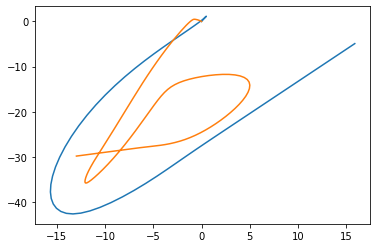

                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50          0.0      0.0367     0.0192
pairs = 2, 10
total time = 6258.8646495342255


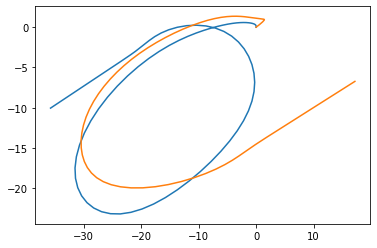

                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50          0.0      0.0249     0.0186
Mistake deriven RF test errors for 5 pairs: 
 [[0.1069]
 [0.1179]
 [0.0681]
 [0.0367]
 [0.0249]]
Mistake deriven RF stds of test error for 5 pairs: 
 [[0.0322]
 [0.0326]
 [0.0264]
 [0.0192]
 [0.0186]]
Mistake deriven RF average test error on 5 pairs: 
 [0.0709]
Mistake deriven RF average stds of test error on 5 pairs: 
 [0.0258]


In [ ]:
perc_RF_errors = []
perc_RF_stds = []

for i in range(len(pairs)):
    m, n = pairs[i]
    print("pairs =", f"{m},", n)

    classif = classification(data[n], data[m], Q_size=20, model='RF', 
                                C=100, gamma=10, classifiers=[], epoch=50, maj_num=11, 
                                init_iter=3, std_coeff=1, test_size=0.3, n_neighbors=5, 
                                n_estimators=50)

    A = classif.classification_Q()
    plt.plot(data[n][0][:,0], data[n][0][:,1])
    plt.plot(data[m][0][:,0], data[m][0][:,1])
    plt.show()

    perc_RF_errors.append(np.round(A[3], decimals=4)) 
    perc_RF_stds.append(np.round(A[4], decimals=4))
    
    print(A[0])
    print("===========================================================================")
    
print(colored(f'Mistake deriven RF test errors for 5 pairs: \n {np.array(perc_RF_errors)}', 'green'))
print(colored(f'Mistake deriven RF stds of test error for 5 pairs: \n {np.array(perc_RF_stds)}', 'magenta'))

print(colored(f'Mistake deriven RF average test error on 5 pairs: \n {list(np.round(np.mean(perc_RF_errors, 0), decimals=4))}', 'yellow'))
print(colored(f'Mistake deriven RF average stds of test error on 5 pairs: \n {list(np.round(np.mean(perc_RF_stds, 0), decimals=4))}', 'blue'))

np.savetxt('/content/gdrive/My Drive/Research/Characters/test errors and stds (Perceptron-like)/RF-error.csv', 
            perc_RF_errors, delimiter=',')
np.savetxt('/content/gdrive/My Drive/Research/Characters/test errors and stds (Perceptron-like)/RF-std.csv', 
            perc_RF_stds, delimiter=',')

np.savetxt('/content/gdrive/My Drive/Research/Characters/test errors and stds (Perceptron-like)/RF-error-ave.csv', 
            np.round(np.mean(perc_RF_errors, 0), decimals=4), delimiter=',')
np.savetxt('/content/gdrive/My Drive/Research/Characters/test errors and stds (Perceptron-like)/RF-std-ave.csv', 
            np.round(np.mean(perc_RF_stds, 0), decimals=4), delimiter=',')


pairs = 15, 17
total time = 2888.778872013092


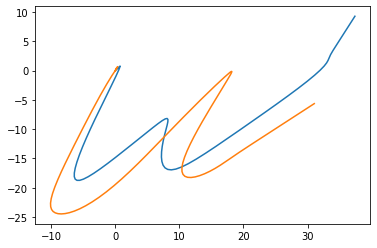

  Classifier  Train Error  Test Error  Std Error
1        KNN       0.0484      0.1105     0.0371
pairs = 9, 17
total time = 2852.06738114357


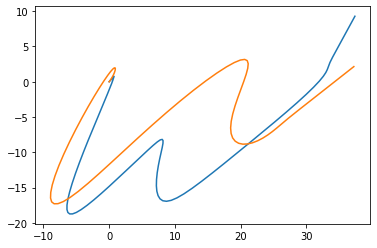

  Classifier  Train Error  Test Error  Std Error
1        KNN       0.0618      0.1714     0.0453
pairs = 9, 15
total time = 2920.804961681366


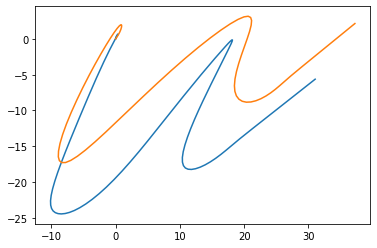

  Classifier  Train Error  Test Error  Std Error
1        KNN       0.0537      0.1175     0.0398
pairs = 1, 7
total time = 3145.8351542949677


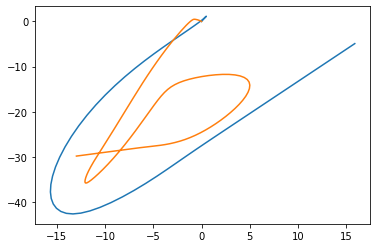

  Classifier  Train Error  Test Error  Std Error
1        KNN       0.0237      0.0471      0.019
pairs = 2, 10
total time = 2887.0168511867523


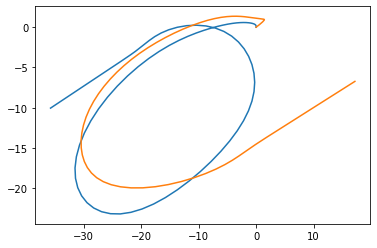

  Classifier  Train Error  Test Error  Std Error
1        KNN       0.0077      0.0188     0.0164
Mistake deriven KNN test errors for 5 pairs: 
 [[0.1105]
 [0.1714]
 [0.1175]
 [0.0471]
 [0.0188]]
Mistake deriven KNN stds of test error for 5 pairs: 
 [[0.0371]
 [0.0453]
 [0.0398]
 [0.019 ]
 [0.0164]]
Mistake deriven KNN average test error on 5 pairs: 
       [0.0931]
Mistake deriven KNN average stds of test error on 5 pairs: 
       [0.0315]


In [ ]:
perc_KNN_errors = []
perc_KNN_stds = []

for i in range(len(pairs)):
    m, n = pairs[i]
    print("pairs =", f"{m},", n)

    classif = classification(data[n], data[m], Q_size=20, model='KNN', 
                                C=100, gamma=10, classifiers=[], epoch=50, maj_num=11, 
                                init_iter=3, std_coeff=1, test_size=0.3, n_neighbors=5, 
                                n_estimators=50)

    A = classif.classification_Q()
    plt.plot(data[n][0][:,0], data[n][0][:,1])
    plt.plot(data[m][0][:,0], data[m][0][:,1])
    plt.show()

    perc_KNN_errors.append(np.round(A[3], decimals=4)) 
    perc_KNN_stds.append(np.round(A[4], decimals=4))
    
    print(A[0])
    print("===========================================================================")
    
print(colored(f'Mistake deriven KNN test errors for 5 pairs: \n {np.array(perc_KNN_errors)}', 'green'))
print(colored(f'Mistake deriven KNN stds of test error for 5 pairs: \n {np.array(perc_KNN_stds)}', 'magenta'))

print(colored(f'Mistake deriven KNN average test error on 5 pairs: \n       {list(np.round(np.mean(perc_KNN_errors, 0), decimals=4))}', 'yellow'))
print(colored(f'Mistake deriven KNN average stds of test error on 5 pairs: \n       {list(np.round(np.mean(perc_KNN_stds, 0), decimals=4))}', 'blue'))

np.savetxt('/content/gdrive/My Drive/Research/Characters/test errors and stds (Perceptron-like)/KNN-error.csv', 
            perc_KNN_errors, delimiter=',')
np.savetxt('/content/gdrive/My Drive/Research/Characters/test errors and stds (Perceptron-like)/KNN-std.csv', 
            perc_KNN_stds, delimiter=',')

np.savetxt('/content/gdrive/My Drive/Research/Characters/test errors and stds (Perceptron-like)/KNN-error-ave.csv', 
            np.round(np.mean(perc_KNN_errors, 0), decimals=4), delimiter=',')
np.savetxt('/content/gdrive/My Drive/Research/Characters/test errors and stds (Perceptron-like)/KNN-std-ave.csv', 
            np.round(np.mean(perc_KNN_stds, 0), decimals=4), delimiter=',')


pairs = 15, 17
total time = 2835.7364954948425


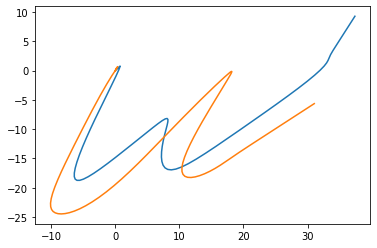

            Classifier  Train Error  Test Error  Std Error
1  Logistic Regression       0.0729      0.0951     0.0348
pairs = 9, 17
total time = 2772.4922485351562


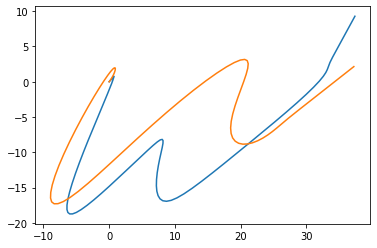

            Classifier  Train Error  Test Error  Std Error
1  Logistic Regression       0.0722       0.139     0.0367
pairs = 9, 15
total time = 2826.434603214264


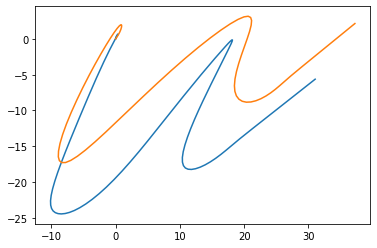

            Classifier  Train Error  Test Error  Std Error
1  Logistic Regression       0.0633      0.0911       0.03
pairs = 1, 7
total time = 3100.6277923583984


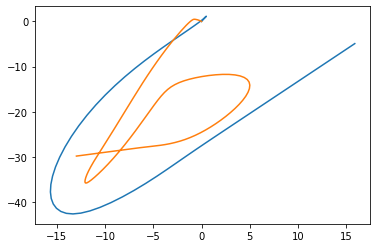

            Classifier  Train Error  Test Error  Std Error
1  Logistic Regression       0.0454      0.0552     0.0196
pairs = 2, 10
total time = 2744.441070318222


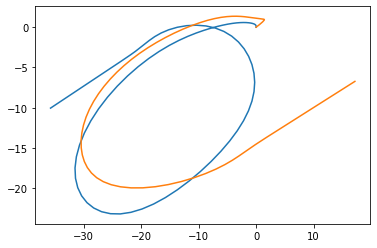

            Classifier  Train Error  Test Error  Std Error
1  Logistic Regression       0.0123      0.0298     0.0179
Mistake deriven LR test errors for 5 pairs: 
 [[0.0951]
 [0.139 ]
 [0.0911]
 [0.0552]
 [0.0298]]
Mistake deriven LR stds of test error for 5 pairs: 
 [[0.0348]
 [0.0367]
 [0.03  ]
 [0.0196]
 [0.0179]]
Mistake deriven LR average test error on 5 pairs: 
       [0.082]
Mistake deriven LR average stds of test error on 5 pairs: 
       [0.0278]


In [ ]:
perc_LR_errors = []
perc_LR_stds = []

for i in range(len(pairs)):
    m, n = pairs[i]
    print("pairs =", f"{m},", n)

    classif = classification(data[n], data[m], Q_size=20, model='LR', 
                                C=100, gamma=10, classifiers=[], epoch=50, maj_num=11, 
                                init_iter=3, std_coeff=1, test_size=0.3, n_neighbors=5, 
                                n_estimators=50)

    A = classif.classification_Q()
    plt.plot(data[n][0][:,0], data[n][0][:,1])
    plt.plot(data[m][0][:,0], data[m][0][:,1])
    plt.show()

    perc_LR_errors.append(np.round(A[3], decimals=4)) 
    perc_LR_stds.append(np.round(A[4], decimals=4))
    
    print(A[0])
    print("===========================================================================")
    
print(colored(f'Mistake deriven LR test errors for 5 pairs: \n {np.array(perc_LR_errors)}', 'green'))
print(colored(f'Mistake deriven LR stds of test error for 5 pairs: \n {np.array(perc_LR_stds)}', 'magenta'))

print(colored(f'Mistake deriven LR average test error on 5 pairs: \n       {list(np.round(np.mean(perc_LR_errors, 0), decimals=4))}', 'yellow'))
print(colored(f'Mistake deriven LR average stds of test error on 5 pairs: \n       {list(np.round(np.mean(perc_LR_stds, 0), decimals=4))}', 'blue'))

np.savetxt('/content/gdrive/My Drive/Research/Characters/test errors and stds (Perceptron-like)/LR-error.csv', 
            perc_LR_errors, delimiter=',')
np.savetxt('/content/gdrive/My Drive/Research/Characters/test errors and stds (Perceptron-like)/LR-std.csv', 
            perc_LR_stds, delimiter=',')

np.savetxt('/content/gdrive/My Drive/Research/Characters/test errors and stds (Perceptron-like)/LR-error-ave.csv', 
            np.round(np.mean(perc_LR_errors, 0), decimals=4), delimiter=',')
np.savetxt('/content/gdrive/My Drive/Research/Characters/test errors and stds (Perceptron-like)/LR-std-ave.csv', 
            np.round(np.mean(perc_LR_stds, 0), decimals=4), delimiter=',')


## MD $v_Q^{\exp}$ with epoch=50, majority=1 and init_num=3

pairs = 15, 17
total time = 242.46252918243408


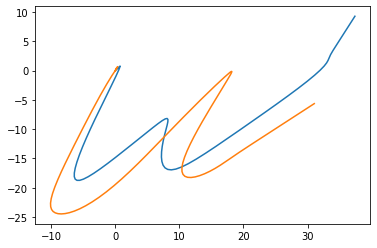

               Classifier  Train Error  Test Error  Std Error
1  SVM, Linear SVC, C=100        0.043      0.1162     0.0389
pairs = 9, 17
total time = 238.63303017616272


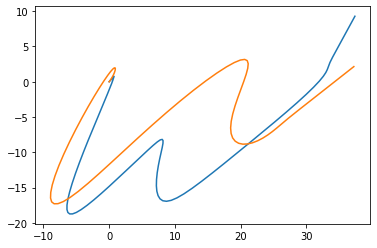

               Classifier  Train Error  Test Error  Std Error
1  SVM, Linear SVC, C=100       0.1137      0.1956     0.0601
pairs = 9, 15
total time = 243.1571261882782


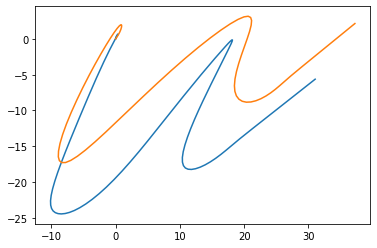

               Classifier  Train Error  Test Error  Std Error
1  SVM, Linear SVC, C=100       0.0815      0.1582     0.0431
pairs = 1, 7
total time = 257.01229906082153


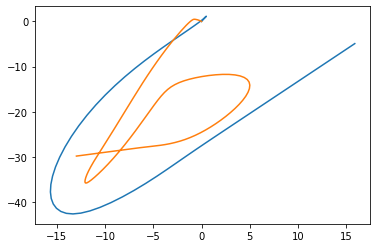

               Classifier  Train Error  Test Error  Std Error
1  SVM, Linear SVC, C=100       0.0081      0.0444     0.0179
pairs = 2, 10
total time = 233.81164598464966


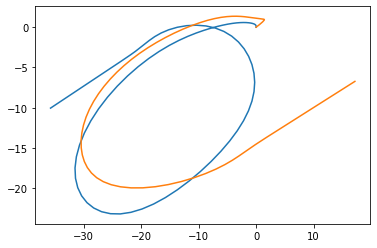

               Classifier  Train Error  Test Error  Std Error
1  SVM, Linear SVC, C=100       0.0018      0.0547     0.0243
Mistake deriven LSVM test errors for 5 pairs: 
 [[0.1162]
 [0.1956]
 [0.1582]
 [0.0444]
 [0.0547]]
Mistake deriven LSVM stds of test error for 5 pairs: 
 [[0.0389]
 [0.0601]
 [0.0431]
 [0.0179]
 [0.0243]]
Mistake deriven LSVM average test error on 5 pairs: 
       [0.1138]
Mistake deriven LSVM average stds of test error on 5 pairs: 
       [0.0369]


In [ ]:
perc_LSVM_errors = []
perc_LSVM_stds = []

for i in range(len(pairs)):
    m, n = pairs[i]
    print("pairs =", f"{m},", n)

    classif = classification(data[n], data[m], Q_size=20, model='LSVM', 
                                C=100, gamma=10, classifiers=[], epoch=50, maj_num=1, 
                                init_iter=3, std_coeff=1, test_size=0.3, n_neighbors=5, 
                                n_estimators=50)

    A = classif.classification_Q()
    plt.plot(data[n][0][:,0], data[n][0][:,1])
    plt.plot(data[m][0][:,0], data[m][0][:,1])
    plt.show()

    perc_LSVM_errors.append(np.round(A[3], decimals=4)) 
    perc_LSVM_stds.append(np.round(A[4], decimals=4))
    
    print(A[0])
    print("===========================================================================")
    
print(colored(f'Mistake deriven LSVM test errors for 5 pairs: \n {np.array(perc_LSVM_errors)}', 'green'))
print(colored(f'Mistake deriven LSVM stds of test error for 5 pairs: \n {np.array(perc_LSVM_stds)}', 'magenta'))

print(colored(f'Mistake deriven LSVM average test error on 5 pairs: \n       {list(np.round(np.mean(perc_LSVM_errors, 0), decimals=4))}', 'yellow'))
print(colored(f'Mistake deriven LSVM average stds of test error on 5 pairs: \n       {list(np.round(np.mean(perc_LSVM_stds, 0), decimals=4))}', 'blue'))

np.savetxt('/content/gdrive/My Drive/Research/Characters/average test errors and stds (Perceptron-like)/LSVM-error.csv', 
            perc_LSVM_errors, delimiter=',')
np.savetxt('/content/gdrive/My Drive/Research/Characters/average test errors and stds (Perceptron-like)/LSVM-std.csv', 
            perc_LSVM_stds, delimiter=',')

np.savetxt('/content/gdrive/My Drive/Research/Characters/average test errors and stds (Perceptron-like)/LSVM-error-ave.csv', 
            np.round(np.mean(perc_LSVM_errors, 0), decimals=4), delimiter=',')
np.savetxt('/content/gdrive/My Drive/Research/Characters/average test errors and stds (Perceptron-like)/LSVM-std-ave.csv', 
            np.round(np.mean(perc_LSVM_stds, 0), decimals=4), delimiter=',')


pairs = 15, 17
total time = 250.9464190006256


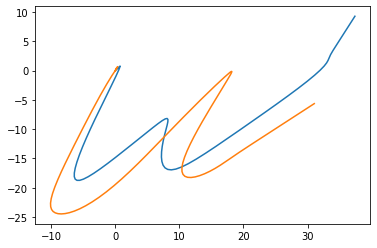

                Classifier  Train Error  Test Error  Std Error
1  GSVM, C=100, gamma=auto          0.0      0.1162     0.0481
pairs = 9, 17
total time = 249.91092109680176


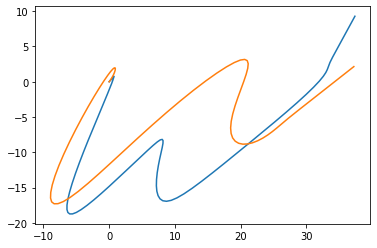

                Classifier  Train Error  Test Error  Std Error
1  GSVM, C=100, gamma=auto          0.0      0.2161     0.0781
pairs = 9, 15
total time = 253.7395510673523


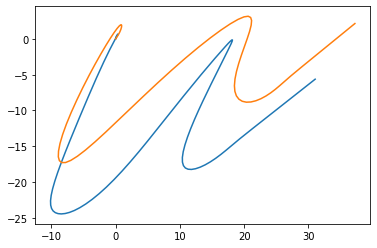

                Classifier  Train Error  Test Error  Std Error
1  GSVM, C=100, gamma=auto          0.0      0.1514     0.0651
pairs = 1, 7
total time = 265.58912444114685


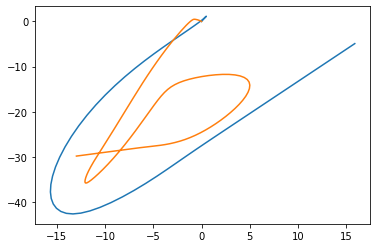

                Classifier  Train Error  Test Error  Std Error
1  GSVM, C=100, gamma=auto          0.0      0.0417     0.0263
pairs = 2, 10
total time = 243.43130493164062


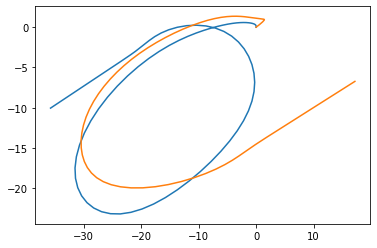

                Classifier  Train Error  Test Error  Std Error
1  GSVM, C=100, gamma=auto          0.0       0.046     0.0276
Mistake deriven GSVM test errors for 5 pairs: 
 [[0.1162]
 [0.2161]
 [0.1514]
 [0.0417]
 [0.046 ]]
Mistake deriven GSVM stds of test error for 5 pairs: 
 [[0.0481]
 [0.0781]
 [0.0651]
 [0.0263]
 [0.0276]]
Mistake deriven GSVM average test error on 5 pairs: 
 [0.1143]
Mistake deriven GSVM average stds of test error on 5 pairs: 
 [0.049]


In [ ]:
perc_GSVM_errors = []
perc_GSVM_stds = []

for i in range(len(pairs)):
    m, n = pairs[i]
    print("pairs =", f"{m},", n)

    classif = classification(data[n], data[m], Q_size=20, model='GSVM', 
                                C=100, gamma='auto', classifiers=[], epoch=50, maj_num=1, 
                                init_iter=3, std_coeff=1, test_size=0.3, n_neighbors=5, 
                                n_estimators=50)

    A = classif.classification_Q()
    plt.plot(data[n][0][:,0], data[n][0][:,1])
    plt.plot(data[m][0][:,0], data[m][0][:,1])
    plt.show()

    perc_GSVM_errors.append(np.round(A[3], decimals=4)) 
    perc_GSVM_stds.append(np.round(A[4], decimals=4))
    
    print(A[0])
    print("===========================================================================")
    
print(colored(f'Mistake deriven GSVM test errors for 5 pairs: \n {np.array(perc_GSVM_errors)}', 'green'))
print(colored(f'Mistake deriven GSVM stds of test error for 5 pairs: \n {np.array(perc_GSVM_stds)}', 'magenta'))

print(colored(f'Mistake deriven GSVM average test error on 5 pairs: \n {list(np.round(np.mean(perc_GSVM_errors, 0), decimals=4))}', 'yellow'))
print(colored(f'Mistake deriven GSVM average stds of test error on 5 pairs: \n {list(np.round(np.mean(perc_GSVM_stds, 0), decimals=4))}', 'blue'))

np.savetxt('/content/gdrive/My Drive/Research/Characters/average test errors and stds (Perceptron-like)/GSVM-error.csv', 
            perc_GSVM_errors, delimiter=',')
np.savetxt('/content/gdrive/My Drive/Research/Characters/average test errors and stds (Perceptron-like)/GSVM-std.csv', 
            perc_GSVM_stds, delimiter=',')

np.savetxt('/content/gdrive/My Drive/Research/Characters/average test errors and stds (Perceptron-like)/GSVM-error-ave.csv', 
            np.round(np.mean(perc_GSVM_errors, 0), decimals=4), delimiter=',')
np.savetxt('/content/gdrive/My Drive/Research/Characters/average test errors and stds (Perceptron-like)/GSVM-std-ave.csv', 
            np.round(np.mean(perc_GSVM_stds, 0), decimals=4), delimiter=',')


pairs = 15, 17


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklea

total time = 255.37248468399048


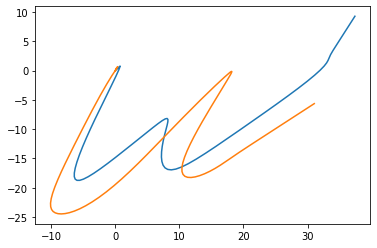

                         Classifier  Train Error  Test Error  Std Error
1  Poly kernel SVM, C=100, deg=auto          0.0      0.1426     0.0423
pairs = 9, 17


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklea

total time = 262.87609791755676


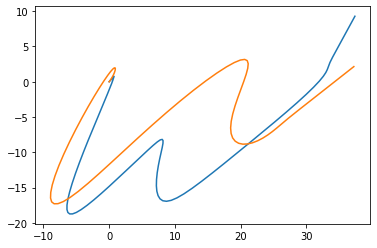

                         Classifier  Train Error  Test Error  Std Error
1  Poly kernel SVM, C=100, deg=auto          0.0      0.2429     0.0627
pairs = 9, 15


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklea

total time = 261.85731172561646


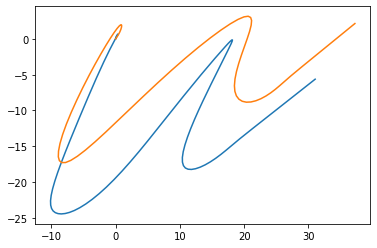

                         Classifier  Train Error  Test Error  Std Error
1  Poly kernel SVM, C=100, deg=auto          0.0      0.1896     0.0592
pairs = 1, 7


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklea

total time = 278.1048946380615


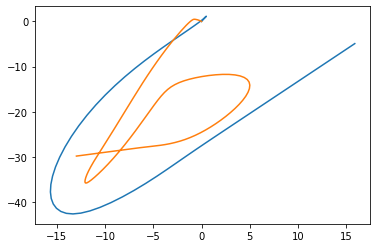

                         Classifier  Train Error  Test Error  Std Error
1  Poly kernel SVM, C=100, deg=auto          0.0      0.0687     0.0292
pairs = 2, 10


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=400000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklea

total time = 249.67563939094543


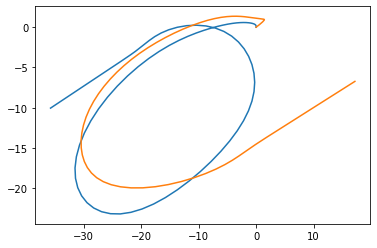

                         Classifier  Train Error  Test Error  Std Error
1  Poly kernel SVM, C=100, deg=auto          0.0       0.073     0.0363
Mistake deriven PSVM test errors for 5 pairs: 
 [[0.1426]
 [0.2429]
 [0.1896]
 [0.0687]
 [0.073 ]]
Mistake deriven PSVM stds of test error for 5 pairs: 
 [[0.0423]
 [0.0627]
 [0.0592]
 [0.0292]
 [0.0363]]
Mistake deriven PSVM average test error on 5 pairs: 
 [0.1434]
Mistake deriven PSVM average stds of test error on 5 pairs: 
 [0.0459]


In [ ]:
perc_PSVM_errors = []
perc_PSVM_stds = []

for i in range(len(pairs)):
    m, n = pairs[i]
    print("pairs =", f"{m},", n)

    classif = classification(data[n], data[m], Q_size=20, model='PSVM', 
                                C=100, gamma=10, classifiers=[], epoch=50, maj_num=1, 
                                init_iter=3, std_coeff=1, test_size=0.3, n_neighbors=5, 
                                n_estimators=50)

    A = classif.classification_Q()
    plt.plot(data[n][0][:,0], data[n][0][:,1])
    plt.plot(data[m][0][:,0], data[m][0][:,1])
    plt.show()

    perc_PSVM_errors.append(np.round(A[3], decimals=4)) 
    perc_PSVM_stds.append(np.round(A[4], decimals=4))
    
    print(A[0])
    print("===========================================================================")
    
print(colored(f'Mistake deriven PSVM test errors for 5 pairs: \n {np.array(perc_PSVM_errors)}', 'green'))
print(colored(f'Mistake deriven PSVM stds of test error for 5 pairs: \n {np.array(perc_PSVM_stds)}', 'magenta'))

print(colored(f'Mistake deriven PSVM average test error on 5 pairs: \n {list(np.round(np.mean(perc_PSVM_errors, 0), decimals=4))}', 'yellow'))
print(colored(f'Mistake deriven PSVM average stds of test error on 5 pairs: \n {list(np.round(np.mean(perc_PSVM_stds, 0), decimals=4))}', 'blue'))

np.savetxt('/content/gdrive/My Drive/Research/Characters/average test errors and stds (Perceptron-like)/PSVM-error.csv', 
            perc_PSVM_errors, delimiter=',')
np.savetxt('/content/gdrive/My Drive/Research/Characters/average test errors and stds (Perceptron-like)/PSVM-std.csv', 
            perc_PSVM_stds, delimiter=',')

np.savetxt('/content/gdrive/My Drive/Research/Characters/average test errors and stds (Perceptron-like)/PSVM-error-ave.csv', 
            np.round(np.mean(perc_PSVM_errors, 0), decimals=4), delimiter=',')
np.savetxt('/content/gdrive/My Drive/Research/Characters/average test errors and stds (Perceptron-like)/PSVM-std-ave.csv', 
            np.round(np.mean(perc_PSVM_stds, 0), decimals=4), delimiter=',')


pairs = 15, 17
total time = 262.42964816093445


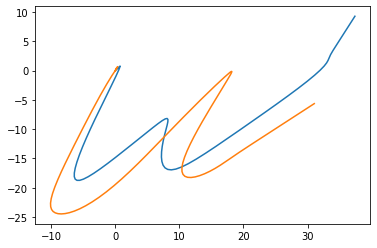

      Classifier  Train Error  Test Error  Std Error
1  Decision Tree          0.0      0.2164     0.0575
pairs = 9, 17
total time = 251.1160044670105


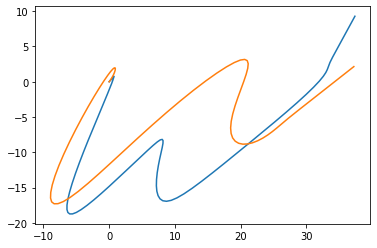

      Classifier  Train Error  Test Error  Std Error
1  Decision Tree          0.0      0.2896     0.0661
pairs = 9, 15
total time = 259.94492197036743


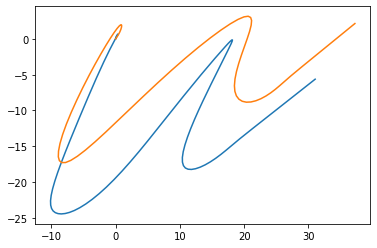

      Classifier  Train Error  Test Error  Std Error
1  Decision Tree          0.0      0.2068     0.0487
pairs = 1, 7
total time = 276.06332564353943


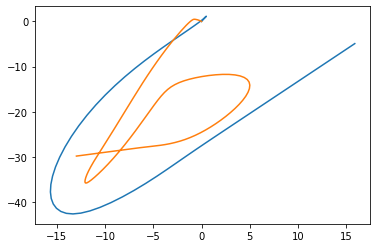

      Classifier  Train Error  Test Error  Std Error
1  Decision Tree          0.0      0.1146     0.0364
pairs = 2, 10
total time = 244.95556616783142


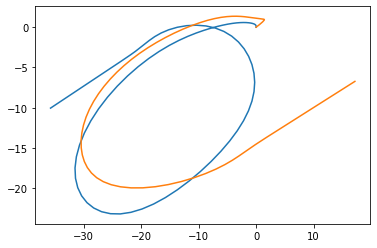

      Classifier  Train Error  Test Error  Std Error
1  Decision Tree          0.0      0.1149     0.0462
Mistake deriven DT test errors for 5 pairs: 
 [[0.2164]
 [0.2896]
 [0.2068]
 [0.1146]
 [0.1149]]
Mistake deriven DT stds of test error for 5 pairs: 
 [[0.0575]
 [0.0661]
 [0.0487]
 [0.0364]
 [0.0462]]
Mistake deriven DT average test error on 5 pairs: 
 [0.1885]
Mistake deriven DT average stds of test error on 5 pairs: 
 [0.051]


In [ ]:
perc_DT_errors = []
perc_DT_stds = []

for i in range(len(pairs)):
    m, n = pairs[i]
    print("pairs =", f"{m},", n)

    classif = classification(data[n], data[m], Q_size=20, model='DT', 
                                C=100, gamma=10, classifiers=[], epoch=50, maj_num=1, 
                                init_iter=3, std_coeff=1, test_size=0.3, n_neighbors=5, 
                                n_estimators=50)

    A = classif.classification_Q()
    plt.plot(data[n][0][:,0], data[n][0][:,1])
    plt.plot(data[m][0][:,0], data[m][0][:,1])
    plt.show()

    perc_DT_errors.append(np.round(A[3], decimals=4)) 
    perc_DT_stds.append(np.round(A[4], decimals=4))
    
    print(A[0])
    print("===========================================================================")
    
print(colored(f'Mistake deriven DT test errors for 5 pairs: \n {np.array(perc_DT_errors)}', 'green'))
print(colored(f'Mistake deriven DT stds of test error for 5 pairs: \n {np.array(perc_DT_stds)}', 'magenta'))

print(colored(f'Mistake deriven DT average test error on 5 pairs: \n {list(np.round(np.mean(perc_DT_errors, 0), decimals=4))}', 'yellow'))
print(colored(f'Mistake deriven DT average stds of test error on 5 pairs: \n {list(np.round(np.mean(perc_DT_stds, 0), decimals=4))}', 'blue'))

np.savetxt('/content/gdrive/My Drive/Research/Characters/average test errors and stds (Perceptron-like)/DT-error.csv', 
            perc_DT_errors, delimiter=',')
np.savetxt('/content/gdrive/My Drive/Research/Characters/average test errors and stds (Perceptron-like)/DT-std.csv', 
            perc_DT_stds, delimiter=',')

np.savetxt('/content/gdrive/My Drive/Research/Characters/average test errors and stds (Perceptron-like)/DT-error-ave.csv', 
            np.round(np.mean(perc_DT_errors, 0), decimals=4), delimiter=',')
np.savetxt('/content/gdrive/My Drive/Research/Characters/average test errors and stds (Perceptron-like)/DT-std-ave.csv', 
            np.round(np.mean(perc_DT_stds, 0), decimals=4), delimiter=',')


pairs = 15, 17
total time = 527.0714139938354


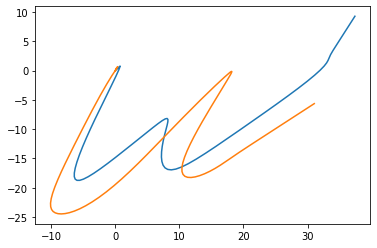

                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50       0.0002      0.1256     0.0392
pairs = 9, 17
total time = 531.2510578632355


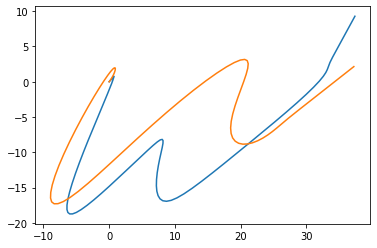

                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50          0.0      0.2122     0.0638
pairs = 9, 15
total time = 530.5839359760284


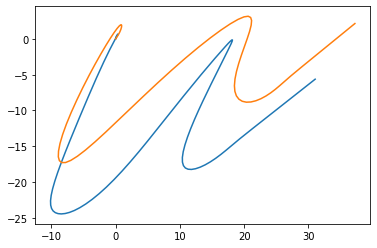

                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50       0.0001      0.0896     0.0446
pairs = 1, 7
total time = 562.3378083705902


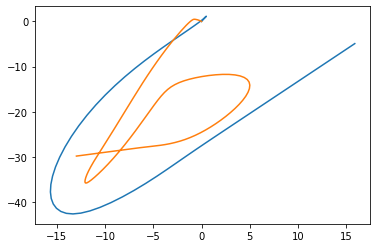

                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50       0.0002      0.0579     0.0257
pairs = 2, 10
total time = 533.852112531662


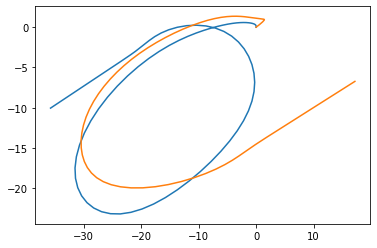

                     Classifier  Train Error  Test Error  Std Error
1  RandomForestClassifier, n=50          0.0      0.0498     0.0302
Mistake deriven RF test errors for 5 pairs: 
 [[0.1256]
 [0.2122]
 [0.0896]
 [0.0579]
 [0.0498]]
Mistake deriven RF stds of test error for 5 pairs: 
 [[0.0392]
 [0.0638]
 [0.0446]
 [0.0257]
 [0.0302]]
Mistake deriven RF average test error on 5 pairs: 
 [0.107]
Mistake deriven RF average stds of test error on 5 pairs: 
 [0.0407]


In [ ]:
perc_RF_errors = []
perc_RF_stds = []

for i in range(len(pairs)):
    m, n = pairs[i]
    print("pairs =", f"{m},", n)

    classif = classification(data[n], data[m], Q_size=20, model='RF', 
                                C=100, gamma=10, classifiers=[], epoch=50, maj_num=1, 
                                init_iter=3, std_coeff=1, test_size=0.3, n_neighbors=5, 
                                n_estimators=50)

    A = classif.classification_Q()
    plt.plot(data[n][0][:,0], data[n][0][:,1])
    plt.plot(data[m][0][:,0], data[m][0][:,1])
    plt.show()

    perc_RF_errors.append(np.round(A[3], decimals=4)) 
    perc_RF_stds.append(np.round(A[4], decimals=4))
    
    print(A[0])
    print("===========================================================================")
    
print(colored(f'Mistake deriven RF test errors for 5 pairs: \n {np.array(perc_RF_errors)}', 'green'))
print(colored(f'Mistake deriven RF stds of test error for 5 pairs: \n {np.array(perc_RF_stds)}', 'magenta'))

print(colored(f'Mistake deriven RF average test error on 5 pairs: \n {list(np.round(np.mean(perc_RF_errors, 0), decimals=4))}', 'yellow'))
print(colored(f'Mistake deriven RF average stds of test error on 5 pairs: \n {list(np.round(np.mean(perc_RF_stds, 0), decimals=4))}', 'blue'))

np.savetxt('/content/gdrive/My Drive/Research/Characters/average test errors and stds (Perceptron-like)/RF-error.csv', 
            perc_RF_errors, delimiter=',')
np.savetxt('/content/gdrive/My Drive/Research/Characters/average test errors and stds (Perceptron-like)/RF-std.csv', 
            perc_RF_stds, delimiter=',')

np.savetxt('/content/gdrive/My Drive/Research/Characters/average test errors and stds (Perceptron-like)/RF-error-ave.csv', 
            np.round(np.mean(perc_RF_errors, 0), decimals=4), delimiter=',')
np.savetxt('/content/gdrive/My Drive/Research/Characters/average test errors and stds (Perceptron-like)/RF-std-ave.csv', 
            np.round(np.mean(perc_RF_stds, 0), decimals=4), delimiter=',')

pairs = 15, 17
total time = 279.46526527404785


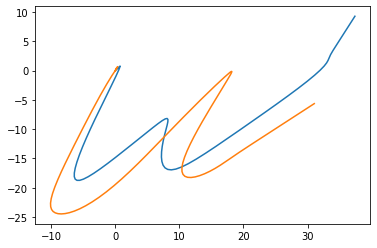

  Classifier  Train Error  Test Error  Std Error
1        KNN       0.0869      0.1423     0.0413
pairs = 9, 17
total time = 276.1472101211548


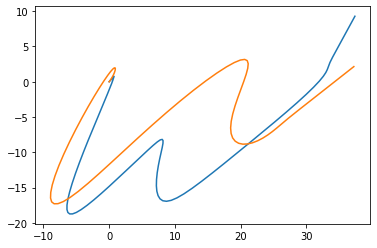

  Classifier  Train Error  Test Error  Std Error
1        KNN        0.142      0.2442     0.0545
pairs = 9, 15
total time = 284.7293016910553


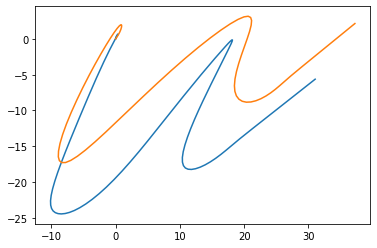

  Classifier  Train Error  Test Error  Std Error
1        KNN       0.1173      0.2028     0.0581
pairs = 1, 7
total time = 305.83204793930054


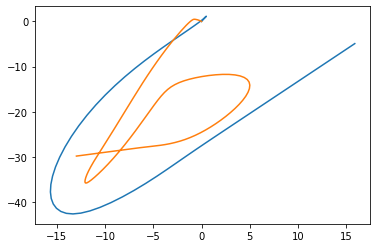

  Classifier  Train Error  Test Error  Std Error
1        KNN       0.0334      0.0673     0.0254
pairs = 2, 10
total time = 276.15025305747986


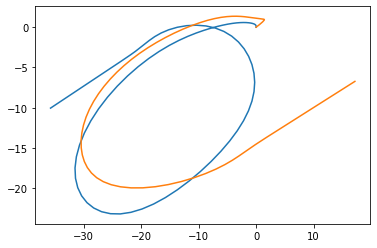

  Classifier  Train Error  Test Error  Std Error
1        KNN        0.039      0.0667     0.0397
Mistake deriven KNN test errors for 5 pairs: 
 [[0.1423]
 [0.2442]
 [0.2028]
 [0.0673]
 [0.0667]]
Mistake deriven KNN stds of test error for 5 pairs: 
 [[0.0413]
 [0.0545]
 [0.0581]
 [0.0254]
 [0.0397]]
Mistake deriven KNN average test error on 5 pairs: 
 [0.1447]
Mistake deriven KNN average stds of test error on 5 pairs: 
 [0.0438]


In [ ]:
perc_KNN_errors = []
perc_KNN_stds = []

for i in range(len(pairs)):
    m, n = pairs[i]
    print("pairs =", f"{m},", n)

    classif = classification(data[n], data[m], Q_size=20, model='KNN', 
                                C=100, gamma=10, classifiers=[], epoch=50, maj_num=1, 
                                init_iter=3, std_coeff=1, test_size=0.3, n_neighbors=5, 
                                n_estimators=50)

    A = classif.classification_Q()
    plt.plot(data[n][0][:,0], data[n][0][:,1])
    plt.plot(data[m][0][:,0], data[m][0][:,1])
    plt.show()

    perc_KNN_errors.append(np.round(A[3], decimals=4)) 
    perc_KNN_stds.append(np.round(A[4], decimals=4))
    
    print(A[0])
    print("===========================================================================")
    
print(colored(f'Mistake deriven KNN test errors for 5 pairs: \n {np.array(perc_KNN_errors)}', 'green'))
print(colored(f'Mistake deriven KNN stds of test error for 5 pairs: \n {np.array(perc_KNN_stds)}', 'magenta'))

print(colored(f'Mistake deriven KNN average test error on 5 pairs: \n {list(np.round(np.mean(perc_KNN_errors, 0), decimals=4))}', 'yellow'))
print(colored(f'Mistake deriven KNN average stds of test error on 5 pairs: \n {list(np.round(np.mean(perc_KNN_stds, 0), decimals=4))}', 'blue'))

np.savetxt('/content/gdrive/My Drive/Research/Characters/average test errors and stds (Perceptron-like)/KNN-error.csv', 
            perc_KNN_errors, delimiter=',')
np.savetxt('/content/gdrive/My Drive/Research/Characters/average test errors and stds (Perceptron-like)/KNN-std.csv', 
            perc_KNN_stds, delimiter=',')

np.savetxt('/content/gdrive/My Drive/Research/Characters/average test errors and stds (Perceptron-like)/KNN-error-ave.csv', 
            np.round(np.mean(perc_KNN_errors, 0), decimals=4), delimiter=',')
np.savetxt('/content/gdrive/My Drive/Research/Characters/average test errors and stds (Perceptron-like)/KNN-std-ave.csv', 
            np.round(np.mean(perc_KNN_stds, 0), decimals=4), delimiter=',')


pairs = 15, 17
total time = 254.63064193725586


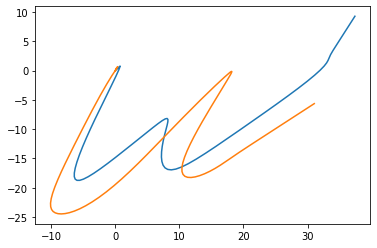

            Classifier  Train Error  Test Error  Std Error
1  Logistic Regression       0.0952      0.1126     0.0321
pairs = 9, 17
total time = 248.98712825775146


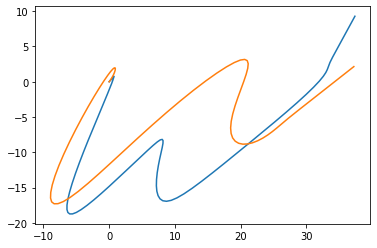

            Classifier  Train Error  Test Error  Std Error
1  Logistic Regression       0.1528      0.2031     0.0647
pairs = 9, 15
total time = 253.95305585861206


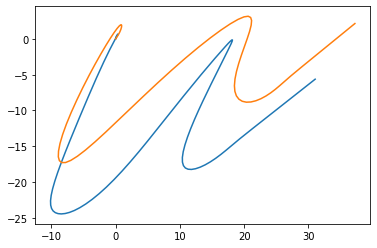

            Classifier  Train Error  Test Error  Std Error
1  Logistic Regression       0.1235      0.1615     0.0531
pairs = 1, 7
total time = 276.74842834472656


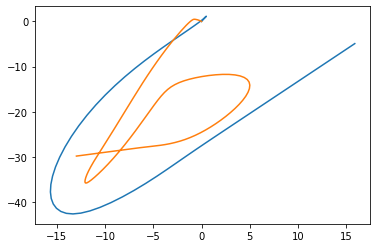

            Classifier  Train Error  Test Error  Std Error
1  Logistic Regression        0.058      0.0765     0.0262
pairs = 2, 10
total time = 247.70415687561035


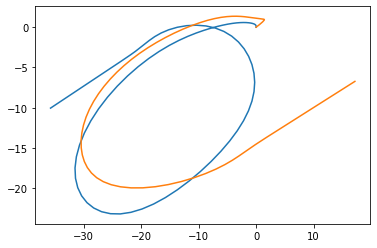

            Classifier  Train Error  Test Error  Std Error
1  Logistic Regression       0.0396      0.0563     0.0344
Mistake deriven LR test errors for 5 pairs: 
 [[0.1126]
 [0.2031]
 [0.1615]
 [0.0765]
 [0.0563]]
Mistake deriven LR stds of test error for 5 pairs: 
 [[0.0321]
 [0.0647]
 [0.0531]
 [0.0262]
 [0.0344]]
Mistake deriven LR average test error on 5 pairs: 
 [0.122]
Mistake deriven LR average stds of test error on 5 pairs: 
 [0.0421]


In [ ]:
perc_LR_errors = []
perc_LR_stds = []

for i in range(len(pairs)):
    m, n = pairs[i]
    print("pairs =", f"{m},", n)

    classif = classification(data[n], data[m], Q_size=20, model='LR', 
                                C=100, gamma=10, classifiers=[], epoch=50, maj_num=1, 
                                init_iter=3, std_coeff=1, test_size=0.3, n_neighbors=5, 
                                n_estimators=50)

    A = classif.classification_Q()
    plt.plot(data[n][0][:,0], data[n][0][:,1])
    plt.plot(data[m][0][:,0], data[m][0][:,1])
    plt.show()

    perc_LR_errors.append(np.round(A[3], decimals=4)) 
    perc_LR_stds.append(np.round(A[4], decimals=4))
    
    print(A[0])
    print("===========================================================================")
    
print(colored(f'Mistake deriven LR test errors for 5 pairs: \n {np.array(perc_LR_errors)}', 'green'))
print(colored(f'Mistake deriven LR stds of test error for 5 pairs: \n {np.array(perc_LR_stds)}', 'magenta'))

print(colored(f'Mistake deriven LR average test error on 5 pairs: \n {list(np.round(np.mean(perc_LR_errors, 0), decimals=4))}', 'yellow'))
print(colored(f'Mistake deriven LR average stds of test error on 5 pairs: \n {list(np.round(np.mean(perc_LR_stds, 0), decimals=4))}', 'blue'))

np.savetxt('/content/gdrive/My Drive/Research/Characters/average test errors and stds (Perceptron-like)/LR-error.csv', 
            perc_LR_errors, delimiter=',')
np.savetxt('/content/gdrive/My Drive/Research/Characters/average test errors and stds (Perceptron-like)/LR-std.csv', 
            perc_LR_stds, delimiter=',')

np.savetxt('/content/gdrive/My Drive/Research/Characters/average test errors and stds (Perceptron-like)/LR-error-ave.csv', 
            np.round(np.mean(perc_LR_errors, 0), decimals=4), delimiter=',')
np.savetxt('/content/gdrive/My Drive/Research/Characters/average test errors and stds (Perceptron-like)/LR-std-ave.csv', 
            np.round(np.mean(perc_LR_stds, 0), decimals=4), delimiter=',')


# Neural Network Classification

## Helper functions

In [ ]:
from collections import Counter

def find_majority(votes):
    vote_count = Counter(votes)
    top = vote_count.most_common(1)
    return top[0][0]

def find_majority_array(A): # column-wise majority
    return list(map(find_majority, A.T))

def ExpCurve2Vec(points, curves, mu):
    D = tt.distsbase.DistsBase()
    a = np.array([np.exp(-1*np.power(D.APntSetDistACrv(points,curve),2)/(mu)**2) for curve in curves])
    return a

def get_endpoints(data):
    n = len(data)
    data_endpoints = np.zeros((n, 4))
    for i in range(n):
        data_endpoints[i] = np.concatenate((data[i][0], data[i][-1]), 0)
    return data_endpoints

def train_test(data_1, data_2, test_size=0.3):
    
    n_1 = len(data_1)
    n_2 = len(data_2) 
    train_idx_1, test_idx_1, train_label_1, test_label_1 \
        = train_test_split(np.arange(n_1), [1] * n_1, test_size = test_size) 
    train_idx_2, test_idx_2, train_label_2, test_label_2 \
        = train_test_split(np.arange(n_2), [0] * n_2, test_size = test_size)

    return train_idx_1, test_idx_1, train_label_1, test_label_1, \
                train_idx_2, test_idx_2, train_label_2, test_label_2

def train_test_mu(data_1, data_2, test_size=0.3):
    
    n_1 = len(data_1)
    n_2 = len(data_2) 
    train_idx_1, test_idx_1, train_label_1, test_label_1 \
        = train_test_split(np.arange(n_1), [1] * n_1, test_size=test_size) 
    train_idx_2, test_idx_2, train_label_2, test_label_2 \
        = train_test_split(np.arange(n_2), [0] * n_2, test_size=test_size)

    train_1 = data_1[train_idx_1]
    train_2 = data_2[train_idx_2]
    test_1 = data_1[test_idx_1]
    test_2 = data_2[test_idx_2]

    arr1 = np.arange(len(train_1)+len(train_2))
    I_1 = np.random.shuffle(arr1)

    arr2 = np.arange(len(test_1)+len(test_2))
    I_2 = np.random.shuffle(arr2)
    
    train = np.concatenate((train_1, train_2), 0)[arr1[I_1]]
    train_labels = np.concatenate((train_label_1, train_label_2), 0)[arr1[I_1]]
    test = np.concatenate((test_1, test_2), 0)[arr2[I_2]]
    test_labels = np.concatenate((test_label_1, test_label_2), 0)[arr2[I_2]]

    a = np.mean([np.mean(train_1[i], 0) for i in range(len(train_1))], 0)
    b = np.mean([np.mean(train_2[i], 0) for i in range(len(train_2))], 0)
    mu = max(abs(a-b))
    
    return mu, train[0], test[0], train_labels[0], test_labels[0]

def flatten(x):
    N = x.shape[0] 
    return x.view(N, -1)

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

## CNN

In [ ]:
def neuralNetworkClassificationCNN(data_1, data_2, Q_size = 20, lr_decay = 0.9, 
                                   learning_rate = 1e-3, num_trials_maj = 11,
                                   out_channels = 10, kernel_size = 10, 
                                   padding = 1, bias = True, Num_updates = 1000, 
                                   D_out = 2, epoch = 50, version = 'unsigned', 
                                   sigma = 1, test_size = 0.3):
    
    """ 
    in_channels: the dimension of hidden layer
    D_out: output dimension
    version: 'signed' or 'unsigned' or 'exp' 
    stride: should be fixed to 1
    """

    start_time = time.time()

    train_errors = np.zeros(epoch)
    test_errors = np.zeros(epoch)

    losses = torch.zeros(epoch, num_trials_maj, Num_updates)
    
    for s in range(epoch):

        mu, train, test, train_labels, test_labels = train_test_mu(data_1, data_2, test_size)

        train_labels = torch.from_numpy(train_labels).long()
        test_labels = torch.from_numpy(test_labels).long()
        
        x_preds = torch.zeros(num_trials_maj, len(train))
        y_preds = torch.zeros(num_trials_maj, len(test))

        Min = np.min([np.min(train[i], 0) for i in range(len(train))], 0)
        Max = np.max([np.max(train[i], 0) for i in range(len(train))], 0)
        Mean = np.mean([np.mean(train[i], 0) for i in range(len(train))], 0)
        Std = np.std([np.std(train[i], 0) for i in range(len(train))], 0)
        
        for t in range(num_trials_maj):
            Q = np.ones((Q_size, 2))
            Q[:,0] = np.random.normal(Mean[0], 4 * Std[0], Q_size)
            Q[:,1] = np.random.normal(Mean[1], 4 * Std[1], Q_size)

            if (version == 'unsigned' or version == 'signed'):
                train_data = curve2vec(Q, train, version = version, sigma = sigma)
                test_data = curve2vec(Q, test, version = version, sigma = sigma)
            elif version == 'exp':
                train_data = ExpCurve2Vec(Q, train, mu)
                test_data = ExpCurve2Vec(Q, test, mu)
            elif version == 'endpoints':
                train_data = get_endpoints(train)
                test_data = get_endpoints(test)
            
            model = nn.Sequential(nn.Conv1d(in_channels = 1, 
                                    out_channels = out_channels, 
                                    kernel_size = kernel_size,
                                    stride  = 1,
                                    padding = padding,
                                    bias = bias),
                                nn.ReLU(),
                                #nn.LeakyReLU(0.01),
                                #nn.Tanh(),
                                Flatten(),
                                nn.Linear(out_channels * (len(train_data[0]) - kernel_size + 1 + 2 * padding), 
                                            D_out)
                                )
    
            loss_fn = torch.nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
            
            train_data = torch.from_numpy(train_data).float()
            test_data = torch.from_numpy(test_data).float()

            train_data = train_data.view(len(train_data), 1, len(train_data[0]))
            
            for k in range(Num_updates):
                x_pred = model(train_data) # of shape (N, D_out)
                loss = loss_fn(x_pred, train_labels)
                losses[s, t, k] = loss
                    
                if (k+1) % 1000 == 0:
                    optimizer.param_groups[0]['lr'] = lr_decay * learning_rate

                optimizer.zero_grad()

                loss.backward() # Backward pass

                optimizer.step()  # Calling the step function on the Optimizer 
                
            x_preds[t] = torch.argmax(model(train_data), axis=1)
            test_data = test_data.view(len(test_data), 1, len(test_data[0]))        
            y_preds[t] = torch.argmax(model(test_data), axis=1)
        
        x_preds = torch.tensor(find_majority_array(x_preds))
        y_preds = torch.tensor(find_majority_array(y_preds))
        
        train_errors[s] = sum(abs(train_labels - x_preds))/len(train_labels)
        test_errors[s] = sum(abs(test_labels - y_preds))/len(test_labels)

    train_error_mean = np.mean(train_errors)
    test_error_mean = np.mean(test_errors)
    test_error_std = np.std(test_errors)

    plt.plot((torch.mean(losses, dim=(0,1))).detach().numpy())
    plt.show()

    Dict = {"CNN 1-Layer": [out_channels, learning_rate, 
               np.round(train_error_mean, decimals=4), 
                np.round(test_error_mean, decimals=4),
                np.round(test_error_std, decimals=4)]}

    pdf = pd.DataFrame.from_dict(Dict, orient='index', 
                columns=['Channel 1', 'Learning Rate', 'Train Error', 
                         'Test Error', 'Std Error'])
    
    print(colored(f"total time = {time.time() - start_time}", "red"))

    return pdf, test_error_mean, test_error_std


### Endpoints

pairs = 15, 17


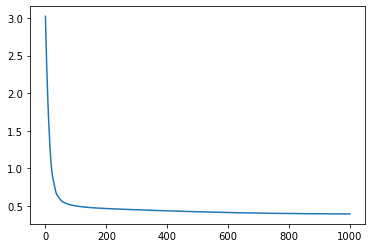

total time = 46.460267782211304
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10          0.001       0.1879      0.2028     0.0342
pairs = 9, 17


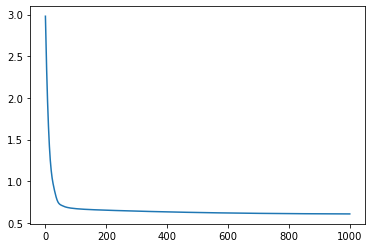

total time = 46.86397695541382
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10          0.001       0.3462       0.354     0.0389
pairs = 9, 15


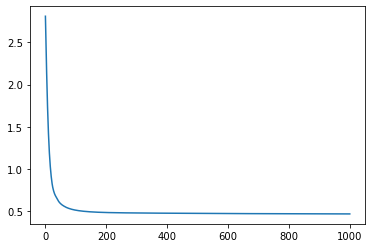

total time = 47.215924978256226
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10          0.001       0.2316      0.2466     0.0387
pairs = 1, 7


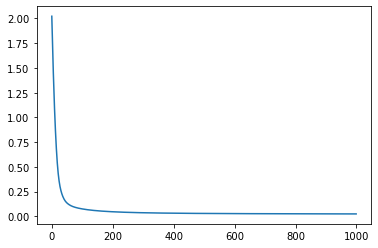

total time = 51.25403094291687
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10          0.001       0.0126      0.0169     0.0127
pairs = 2, 10


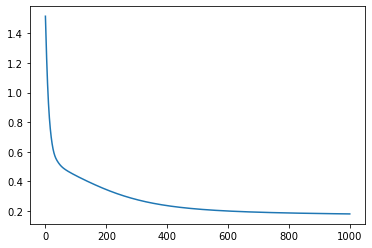

total time = 48.18103623390198
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10          0.001       0.0757      0.0877     0.0266
test errors for 5 pairs: 
 [0.2028 0.354  0.2466 0.0169 0.0877]
stds of test error for 5 pairs: 
 [0.0342 0.0389 0.0387 0.0127 0.0266]
average test error on 5 pairs: 
 0.1816
average stds of test error on 5 pairs: 
 0.0302


In [ ]:
endpoints_errors = []
endpoints_stds = []

for i in range(len(pairs)):
    m, n = pairs[i]
    print("pairs =", f"{m},", n)
    
    A = neuralNetworkClassificationCNN(data[n], data[m], Q_size = 20, lr_decay = 0.9, 
                                       learning_rate = 1e-3, num_trials_maj = 1,
                                       out_channels = 10, kernel_size = 2,  
                                       padding = 1, bias = True, Num_updates = 1000, 
                                       D_out = 2, epoch = 50, version = 'endpoints', 
                                       sigma = 100, test_size = 0.3)

    endpoints_errors.append(np.round(A[1], decimals=4)) 
    endpoints_stds.append(np.round(A[2], decimals=4))
    
    print(A[0])
    print("===========================================================================")
    
print(colored(f'test errors for 5 pairs: \n {np.array(endpoints_errors)}', 'green'))
print(colored(f'stds of test error for 5 pairs: \n {np.array(endpoints_stds)}', 'magenta'))

print(colored(f'average test error on 5 pairs: \n {np.round(np.mean(endpoints_errors, 0), decimals=4)}', 'yellow'))
print(colored(f'average stds of test error on 5 pairs: \n {np.round(np.mean(endpoints_stds, 0), decimals=4)}', 'blue'))


### |Q|=20

### Majority = 1

#### Rand($v_Q$)

pairs = 15, 17


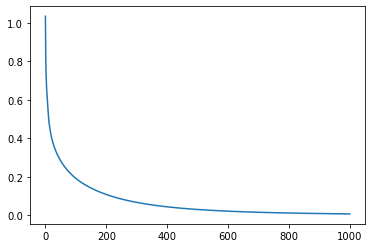

total time = 64.2033998966217
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10          0.002       0.0004      0.1187     0.0428
pairs = 9, 17


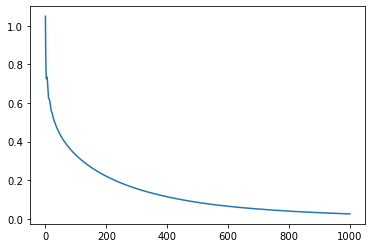

total time = 60.05164122581482
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10          0.002        0.002       0.207     0.0548
pairs = 9, 15


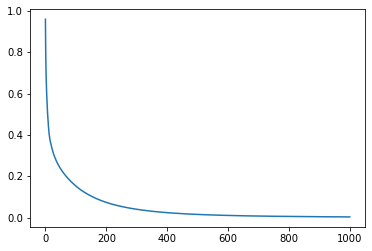

total time = 65.12040400505066
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10          0.002          0.0      0.0904     0.0343
pairs = 1, 7


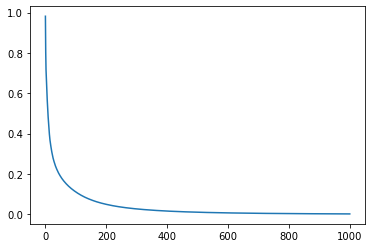

total time = 70.88050270080566
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10          0.002          0.0      0.0425     0.0218
pairs = 2, 10


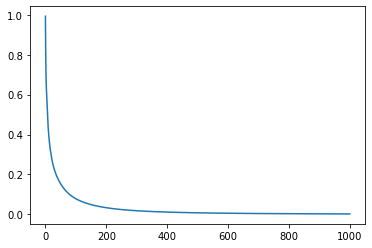

total time = 70.33952188491821
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10          0.002          0.0      0.0416      0.026
test errors for 5 pairs: [0.1187 0.207  0.0904 0.0425 0.0416]
stds of test error for 5 pairs: [0.0428 0.0548 0.0343 0.0218 0.026 ]
average test error on 5 pairs: 0.1
average stds of test error on 5 pairs: 0.0359


In [ ]:
errors = []
stds = []

for i in range(len(pairs)):
    m, n = pairs[i]
    print("pairs =", f"{m},", n)
    
    A = neuralNetworkClassificationCNN(data[n], data[m], Q_size = 20, lr_decay = 0.9, 
                                       learning_rate = 2e-3, num_trials_maj = 1,
                                       out_channels = 10, kernel_size = 5,  
                                       padding = 1, bias = True, Num_updates = 1000, 
                                       D_out = 2, epoch = 50, version = 'unsigned', 
                                       sigma = 100, test_size = 0.3)

    errors.append(np.round(A[1], decimals=4)) 
    stds.append(np.round(A[2], decimals=4))
    
    print(A[0])
    print("===========================================================================")
    
print(colored(f'test errors for 5 pairs: {np.array(errors)}', 'green'))
print(colored(f'stds of test error for 5 pairs: {np.array(stds)}', 'magenta'))

print(colored(f'average test error on 5 pairs: {np.round(np.mean(errors, 0), decimals=4)}', 'yellow'))
print(colored(f'average stds of test error on 5 pairs: {np.round(np.mean(stds, 0), decimals=4)}', 'blue'))


#### Rand($v_Q^{\varsigma}$)

pairs = 15, 17


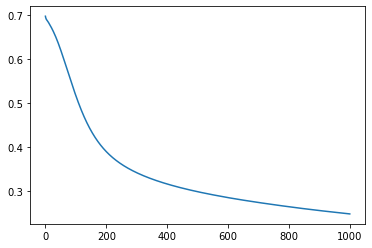

total time = 77.82178401947021
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10          0.002       0.0962      0.1336     0.0417
pairs = 9, 17


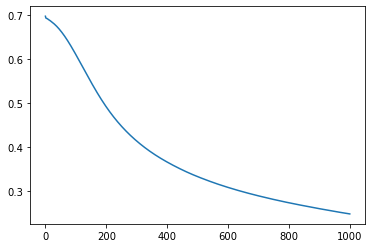

total time = 71.53586721420288
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10          0.002       0.0996      0.1558     0.0561
pairs = 9, 15


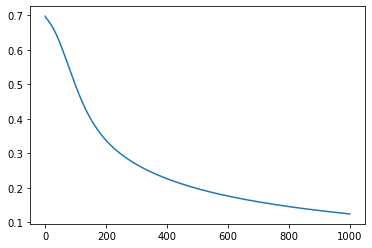

total time = 69.08730006217957
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10          0.002       0.0396      0.0666     0.0432
pairs = 1, 7


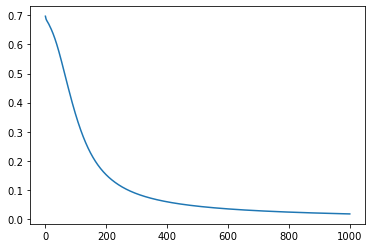

total time = 77.22731280326843
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10          0.002       0.0036      0.0106     0.0136
pairs = 2, 10


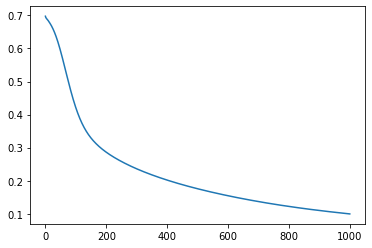

total time = 70.07355904579163
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10          0.002       0.0345      0.0556     0.0331
test errors for 5 pairs: [0.1336 0.1558 0.0666 0.0106 0.0556]
stds of test error for 5 pairs: [0.0417 0.0561 0.0432 0.0136 0.0331]
average test error on 5 pairs: 0.0844
average stds of test error on 5 pairs: 0.0375


In [ ]:
errors = []
stds = []

for i in range(len(pairs)):
    m, n = pairs[i]
    print("pairs =", f"{m},", n)
    
    A = neuralNetworkClassificationCNN(data[n], data[m], Q_size = 20, lr_decay = 0.9, 
                                       learning_rate = 2e-3, num_trials_maj = 1,
                                       out_channels = 10, kernel_size = 5,  
                                       padding = 1, bias = True, Num_updates = 1000, 
                                       D_out = 2, epoch = 50, version = 'signed', 
                                       sigma = 100, test_size = 0.3)

    errors.append(np.round(A[1], decimals=4)) 
    stds.append(np.round(A[2], decimals=4))
    
    print(A[0])
    print("===========================================================================")
    
print(colored(f'test errors for 5 pairs: {np.array(errors)}', 'green'))
print(colored(f'stds of test error for 5 pairs: {np.array(stds)}', 'magenta'))

print(colored(f'average test error on 5 pairs: {np.round(np.mean(errors, 0), decimals=4)}', 'yellow'))
print(colored(f'average stds of test error on 5 pairs: {np.round(np.mean(stds, 0), decimals=4)}', 'blue'))


#### Rand($v_Q^{exp}$)

pairs = 15, 17


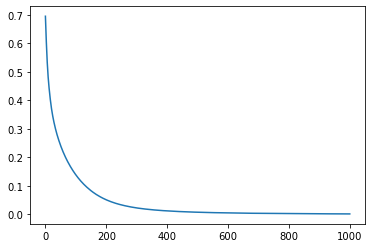

total time = 61.104767084121704
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01          0.0      0.1464     0.0526
pairs = 9, 17


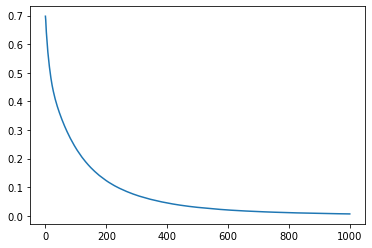

total time = 69.51640295982361
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.0001      0.2457      0.066
pairs = 9, 15


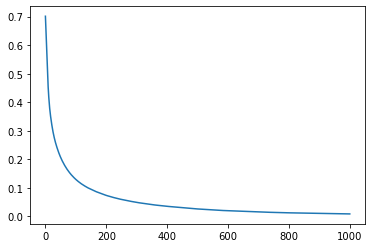

total time = 72.77267980575562
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.0012      0.0853     0.0376
pairs = 1, 7


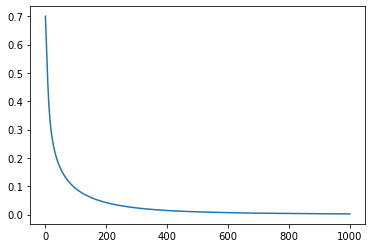

total time = 65.95422387123108
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.0001      0.0525     0.0222
pairs = 2, 10


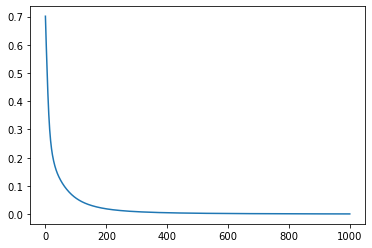

total time = 58.181313037872314
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01          0.0      0.0684     0.0356
test errors for 5 pairs: [0.1464 0.2457 0.0853 0.0525 0.0684]
stds of test error for 5 pairs: [0.0526 0.066  0.0376 0.0222 0.0356]
average test error on 5 pairs: 0.1197
average stds of test error on 5 pairs: 0.0428


In [ ]:
errors = []
stds = []

for i in range(len(pairs)):
    m, n = pairs[i]
    print("pairs =", f"{m},", n)
    
    A = neuralNetworkClassificationCNN(data[n], data[m], Q_size = 20, lr_decay = 0.9, 
                                       learning_rate = 1e-2, num_trials_maj = 1,
                                       out_channels = 10, kernel_size = 5,  
                                       padding = 1, bias = True, Num_updates = 1000, 
                                       D_out = 2, epoch = 50, version = 'exp', 
                                       sigma = 100, test_size = 0.3)

    errors.append(np.round(A[1], decimals=4)) 
    stds.append(np.round(A[2], decimals=4))
    
    print(A[0])
    print("===========================================================================")
    
print(colored(f'test errors for 5 pairs: {np.array(errors)}', 'green'))
print(colored(f'stds of test error for 5 pairs: {np.array(stds)}', 'magenta'))

print(colored(f'average test error on 5 pairs: {np.round(np.mean(errors, 0), decimals=4)}', 'yellow'))
print(colored(f'average stds of test error on 5 pairs: {np.round(np.mean(stds, 0), decimals=4)}', 'blue'))


### Majority = 11

#### Vote(Rand $v_Q$)

pairs = 15, 17


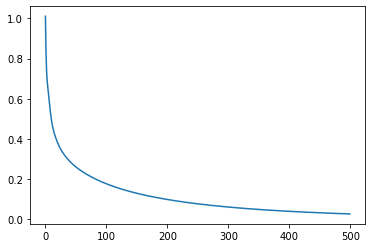

total time = 372.721962928772
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10          0.002       0.0042      0.1133     0.0342
pairs = 9, 17


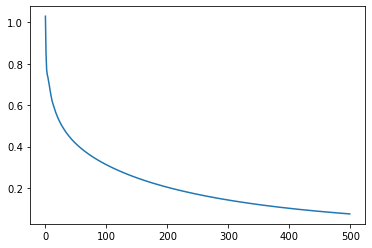

total time = 317.2985541820526
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10          0.002       0.0183      0.1932      0.054
pairs = 9, 15


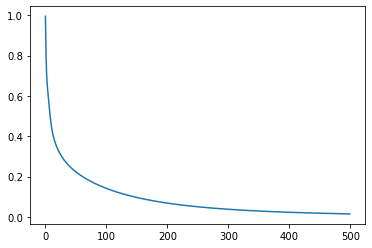

total time = 319.86326003074646
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10          0.002       0.0008      0.0767      0.034
pairs = 1, 7


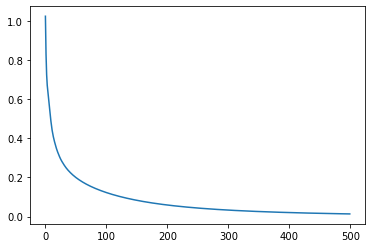

total time = 338.079363822937
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10          0.002       0.0005      0.0413      0.022
pairs = 2, 10


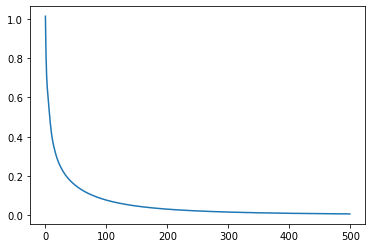

total time = 320.7508590221405
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10          0.002       0.0003      0.0398     0.0289
test errors for 5 pairs: [0.1133 0.1932 0.0767 0.0413 0.0398]
stds of test error for 5 pairs: [0.0342 0.054  0.034  0.022  0.0289]
average test error on 5 pairs: 0.0929
average stds of test error on 5 pairs: 0.0346


In [ ]:
errors = []
stds = []

for i in range(len(pairs)):
    m, n = pairs[i]
    print("pairs =", f"{m},", n)
    
    A = neuralNetworkClassificationCNN(data[n], data[m], Q_size = 20, lr_decay = 0.9, 
                                       learning_rate = 2e-3, num_trials_maj = 11,
                                       out_channels = 10, kernel_size = 5,  
                                       padding = 1, bias = True, Num_updates = 500, 
                                       D_out = 2, epoch = 50, version = 'unsigned', 
                                       sigma = 100, test_size = 0.3)

    errors.append(np.round(A[1], decimals=4)) 
    stds.append(np.round(A[2], decimals=4))
    
    print(A[0])
    print("===========================================================================")
    
print(colored(f'test errors for 5 pairs: {np.array(errors)}', 'green'))
print(colored(f'stds of test error for 5 pairs: {np.array(stds)}', 'magenta'))

print(colored(f'average test error on 5 pairs: {np.round(np.mean(errors, 0), decimals=4)}', 'yellow'))
print(colored(f'average stds of test error on 5 pairs: {np.round(np.mean(stds, 0), decimals=4)}', 'blue'))


#### Vote(Rand $v_Q^{\varsigma}$)

pairs = 15, 17


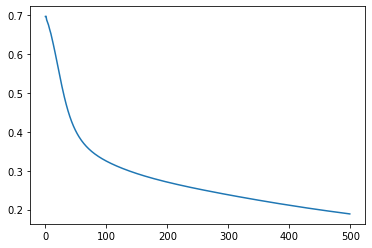

total time = 346.7472529411316
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.0739      0.1228     0.0391
pairs = 9, 17


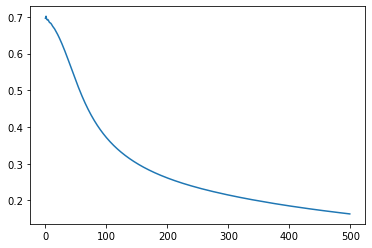

total time = 372.75756192207336
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.0589      0.1288     0.0458
pairs = 9, 15


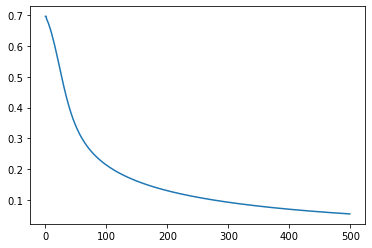

total time = 347.0442531108856
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.0131      0.0565     0.0325
pairs = 1, 7


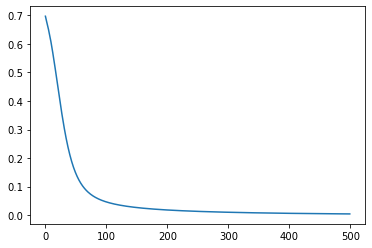

total time = 368.45384669303894
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.0003       0.011     0.0103
pairs = 2, 10


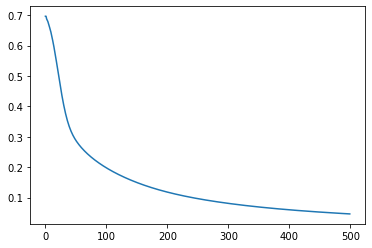

total time = 351.570200920105
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.0138      0.0449     0.0234
test errors for 5 pairs: [0.1228 0.1288 0.0565 0.011  0.0449]
stds of test error for 5 pairs: [0.0391 0.0458 0.0325 0.0103 0.0234]
average test error on 5 pairs: 0.0728
average stds of test error on 5 pairs: 0.0302


In [ ]:
errors = []
stds = []

for i in range(len(pairs)):
    m, n = pairs[i]
    print("pairs =", f"{m},", n)
    
    A = neuralNetworkClassificationCNN(data[n], data[m], Q_size = 20, lr_decay = 0.9, 
                                       learning_rate = 1e-2, num_trials_maj = 11,
                                       out_channels = 10, kernel_size = 5,  
                                       padding = 1, bias = True, Num_updates = 500, 
                                       D_out = 2, epoch = 50, version = 'signed', 
                                       sigma = 100, test_size = 0.3)

    errors.append(np.round(A[1], decimals=4)) 
    stds.append(np.round(A[2], decimals=4))
    
    print(A[0])
    print("===========================================================================")
    
print(colored(f'test errors for 5 pairs: {np.array(errors)}', 'green'))
print(colored(f'stds of test error for 5 pairs: {np.array(stds)}', 'magenta'))

print(colored(f'average test error on 5 pairs: {np.round(np.mean(errors, 0), decimals=4)}', 'yellow'))
print(colored(f'average stds of test error on 5 pairs: {np.round(np.mean(stds, 0), decimals=4)}', 'blue'))


#### Vote(Rand $v_Q^{exp}$)

pairs = 15, 17


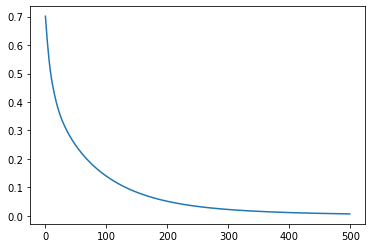

total time = 311.80053186416626
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01          0.0      0.1495     0.0474
pairs = 9, 17


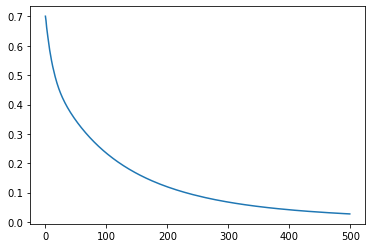

total time = 312.65389704704285
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01        0.002      0.2348     0.0482
pairs = 9, 15


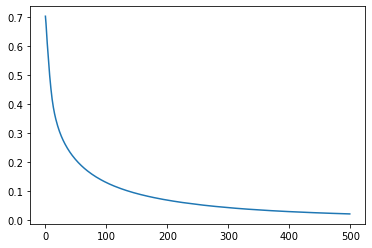

total time = 314.72175788879395
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.0025      0.0787     0.0333
pairs = 1, 7


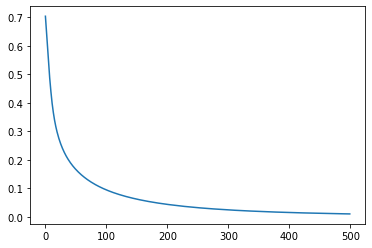

total time = 334.77583289146423
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.0025      0.0498     0.0307
pairs = 2, 10


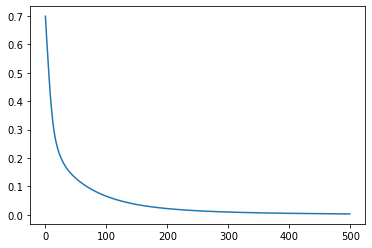

total time = 321.80512595176697
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01          0.0      0.0788     0.0391
test errors for 5 pairs: [0.1495 0.2348 0.0787 0.0498 0.0788]
stds of test error for 5 pairs: [0.0474 0.0482 0.0333 0.0307 0.0391]
average test error on 5 pairs: 0.1183
average stds of test error on 5 pairs: 0.0397


In [ ]:
errors = []
stds = []

for i in range(len(pairs)):
    m, n = pairs[i]
    print("pairs =", f"{m},", n)
    
    A = neuralNetworkClassificationCNN(data[n], data[m], Q_size = 20, lr_decay = 0.9, 
                                       learning_rate = 1e-2, num_trials_maj = 11,
                                       out_channels = 10, kernel_size = 5,  
                                       padding = 1, bias = True, Num_updates = 500, 
                                       D_out = 2, epoch = 50, version = 'exp', 
                                       sigma = 100, test_size = 0.3)

    errors.append(np.round(A[1], decimals=4)) 
    stds.append(np.round(A[2], decimals=4))
    
    print(A[0])
    print("===========================================================================")
    
print(colored(f'test errors for 5 pairs: {np.array(errors)}', 'green'))
print(colored(f'stds of test error for 5 pairs: {np.array(stds)}', 'magenta'))

print(colored(f'average test error on 5 pairs: {np.round(np.mean(errors, 0), decimals=4)}', 'yellow'))
print(colored(f'average stds of test error on 5 pairs: {np.round(np.mean(stds, 0), decimals=4)}', 'blue'))


# Neural Network for Mistake Driven Method of Choosing Q

## Initialize Q

In [ ]:
def initialize_Q(train_1, train_2, std_coeff, out_channels, kernel_size, Q_size, 
                 padding, learning_rate = 1e-3, bias = True, D_out=2, lr_decay = 0.9, 
                 Num_updates = 100): 
        
    Q = []
    errors = []
    losses = np.zeros((Q_size - kernel_size, Num_updates))
    
    mu = get_mu(train_1, train_2)
    std = mu * std_coeff

    trajectory_train_data = np.concatenate((train_1, train_2), axis = 0)
    train_labels = np.concatenate(([1] * len(train_1), [0] * len(train_2)), 0)
    train_labels = torch.from_numpy(train_labels).long()
    index = np.random.randint(0, high=len(trajectory_train_data)) 
    k = np.random.randint(0, high=len(trajectory_train_data[index]))
    for i in range(kernel_size):
        q = trajectory_train_data[index][k] + np.random.normal(0, std, 2)
        Q.append(q)

    for i in range(Q_size - kernel_size):
        train_data = ExpCurve2Vec(np.array(Q), trajectory_train_data, mu)
        model = nn.Sequential(nn.Conv1d(in_channels = 1, 
                            out_channels = out_channels, 
                            kernel_size = kernel_size,
                            stride  = 1,
                            padding = padding,
                            bias = bias),
                nn.ReLU(),
                #nn.LeakyReLU(0.01),
                #nn.Tanh(),
                Flatten(),
                nn.Linear(out_channels * (len(train_data[0]) - kernel_size + 1 + 2 * padding), 
                            D_out)
                )
    
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        
        train_data = torch.from_numpy(train_data).float()
        train_data = train_data.view(len(train_data), 1, len(train_data[0]))
        
        for k in range(Num_updates):
            x_pred = model(train_data) # of shape (N, D_out)
            loss = loss_fn(x_pred, train_labels)
            losses[i, k] = loss
            
            if (k+1) % 100 == 0:
                optimizer.param_groups[0]['lr'] = lr_decay * learning_rate
            optimizer.zero_grad()
            loss.backward() 
            optimizer.step() 
        
        train_pred = torch.argmax(model(train_data), axis=1)
        scores = model(train_data)
        I = np.where((train_labels == train_pred) == False)[0]

        temp_labels = 2 * train_labels.numpy().reshape(len(train_labels.numpy()), 1) - 1
        temp = temp_labels * scores.detach().numpy()
        temp = np.max(temp, axis=1)
        index = I[np.argmax(temp[I])]

        error = sum(train_labels != train_pred)/len(train_labels)
        errors.append(error.item())
        
        k = np.random.randint(0, high=len(trajectory_train_data[index]))
        q = trajectory_train_data[index][k] + np.random.normal(0, std, 2)
        Q.append(q)

    final_error = errors[-1]

    #plt.plot((np.mean(losses, axis=0)))
    #plt.show()

    return np.array(Q), np.array(errors), mu, final_error

## Mistake Driven with CNN

In [ ]:
def MD_NeuralNetworkClassificationCNN(data_1, data_2, maj_num, epoch, init_iter, 
                                      test_size, std_coeff, out_channels, kernel_size, 
                                      Q_size, padding, learning_rate = 1e-3, 
                                      bias = True, D_out=2, lr_decay = 0.9, 
                                      Num_updates = 100):
        
    start_time = time.time()

    train_errors = np.zeros(epoch) 
    test_errors = np.zeros(epoch)

    n_1 = len(data_1)
    n_2 = len(data_2) 

    for s in range(epoch):
        train_idx_1, test_idx_1, train_label_1, test_label_1, train_idx_2, \
        test_idx_2, train_label_2, test_label_2 = train_test(data_1, data_2, test_size)

        train = np.concatenate((data_1[train_idx_1], data_2[train_idx_2]), 0)
        test = np.concatenate((data_1[test_idx_1], data_2[test_idx_2]), 0)
        train_labels = np.concatenate((train_label_1, train_label_2), axis = 0)
        test_labels = np.concatenate((test_label_1, test_label_2), axis = 0)
        train_labels = torch.from_numpy(train_labels).long()
        test_labels = torch.from_numpy(test_labels).long()

        x_preds = torch.zeros((maj_num, len(train)))
        y_preds = torch.zeros((maj_num, len(test)))
        
        I = np.arange(len(train))
        np.random.shuffle(I)
        train = train[I]
        train_labels = train_labels[I]
        
        J = np.arange(len(test))
        np.random.shuffle(J)
        test = test[J]
        test_labels = test_labels[J]

        for t in range(maj_num):

            Q_list = []
            temp_errors = []
            mu_temp = []

            for j in range(init_iter):
                B = initialize_Q(data_1[train_idx_1], data_2[train_idx_2], 
                                 std_coeff, out_channels, kernel_size, Q_size, 
                                 padding, learning_rate = 1e-3, bias = True, 
                                 D_out=2, lr_decay = 0.9, Num_updates = 100)

                Q_list.append(B[0])
                mu_temp.append(B[2])
                temp_errors.append(B[-1])

            h = np.argmin(temp_errors)
            Q = Q_list[h]
            mu = mu_temp[h]

            train_data = torch.from_numpy(ExpCurve2Vec(Q, train, mu)).float()
            train_data = train_data.view(len(train_data), 1, len(train_data[0]))

            test_data = torch.from_numpy(ExpCurve2Vec(Q, test, mu)).float()
            test_data = test_data.view(len(test_data), 1, len(test_data[0]))

            model = nn.Sequential(nn.Conv1d(in_channels = 1, 
                                    out_channels = out_channels, 
                                    kernel_size = kernel_size,
                                    stride  = 1,
                                    padding = padding,
                                    bias = bias),
                    nn.ReLU(),
                    #nn.LeakyReLU(0.01),
                    #nn.Tanh(),
                    Flatten(),
                    nn.Linear(out_channels * (len(train_data[0][0]) - kernel_size + 1 + 2 * padding), 
                              D_out)
                    )
        
            loss_fn = torch.nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        
            for k in range(Num_updates):
                x_pred = model(train_data) # of shape (N, D_out)
                loss = loss_fn(x_pred, train_labels)

                if (k+1) % 10 == 0:
                    optimizer.param_groups[0]['lr'] = lr_decay * learning_rate
                optimizer.zero_grad()
                loss.backward() 
                optimizer.step() 

            scores = model(train_data)
            
            x_preds[t] = torch.argmax(scores, axis=1)
            y_preds[t] = torch.argmax(model(test_data), axis=1)

        x_preds = torch.tensor(find_majority_array(x_preds))
        y_preds = torch.tensor(find_majority_array(y_preds))

        train_errors[s] = sum(abs(train_labels - x_preds))/len(train_labels)
        test_errors[s] = sum(abs(test_labels - y_preds))/len(test_labels)

    train_error_mean = np.mean(train_errors)
    test_error_mean = np.mean(test_errors)
    test_error_std = np.std(test_errors)

    Dict = {"CNN 1-Layer": [out_channels, learning_rate, 
                            np.round(train_error_mean, decimals = 4), 
                            np.round(test_error_mean, decimals = 4),
                            np.round(test_error_std, decimals = 4)]}

    pdf = pd.DataFrame.from_dict(Dict, orient='index', 
                                 columns=['Channel 1', 'Learning Rate', 
                                          'Train Error', 'Test Error', 'Std Error'])

    print(colored(f"total time = {time.time() - start_time}", "red"))
    print("mu =", mu)

    return pdf, test_error_mean, test_error_std


## With num_maj = 1

In [ ]:
errors = []
stds = []

for i in range(len(pairs)):
    m, n = pairs[i]
    print("pairs =", f"{m},", n)
    
    A = MD_NeuralNetworkClassificationCNN(data[m], data[n], maj_num=1, epoch=50, init_iter=3, 
                                          test_size=0.3, std_coeff=1, out_channels=10, 
                                          kernel_size = 5, Q_size = 10, padding = 1, 
                                          learning_rate = 1e-2, bias = True, D_out=2, 
                                          lr_decay = 0.9, Num_updates = 1000)

    errors.append(np.round(A[1], decimals=4)) 
    stds.append(np.round(A[2], decimals=4))
    
    print(A[0])
    print("===========================================================================")
    
print(colored(f'test errors for 5 pairs: {np.array(errors)}', 'green'))
print(colored(f'stds of test error for 5 pairs: {np.array(stds)}', 'magenta'))

print(colored(f'average test error on 5 pairs: {np.round(np.mean(errors, 0), decimals=4)}', 'yellow'))
print(colored(f'average stds of test error on 5 pairs: {np.round(np.mean(stds, 0), decimals=4)}', 'blue'))


pairs = 15, 17


../aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


total time = 139.2382209300995
mu = 3.7349414851221265
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.0333      0.2205     0.0606
pairs = 9, 17
total time = 133.607971906662
mu = 3.155227219554659
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.0734      0.3055      0.076
pairs = 9, 15
total time = 136.44990420341492
mu = 6.035980618587036
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.0223      0.1147     0.0719
pairs = 1, 7
total time = 143.72747421264648
mu = 5.107526791047189
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.0414      0.1313      0.061
pairs = 2, 10
total time = 138.06705904006958
mu = 1.627631282702401
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-

## With num_maj = 11

In [ ]:
errors = []
stds = []

for i in range(len(pairs)):
    m, n = pairs[i]
    print("pairs =", f"{m},", n)
    
    A = MD_NeuralNetworkClassificationCNN(data[m], data[n], maj_num=11, epoch=50, init_iter=3, 
                                          test_size=0.3, std_coeff=1, out_channels=10, 
                                          kernel_size = 5, Q_size = 10, padding = 1, 
                                          learning_rate = 1e-2, bias = True, D_out=2, 
                                          lr_decay = 0.9, Num_updates = 1000)

    errors.append(np.round(A[1], decimals=4)) 
    stds.append(np.round(A[2], decimals=4))
    
    print(A[0])
    print("===========================================================================")
    
print(colored(f'test errors for 5 pairs: {np.array(errors)}', 'green'))
print(colored(f'stds of test error for 5 pairs: {np.array(stds)}', 'magenta'))

print(colored(f'average test error on 5 pairs: {np.round(np.mean(errors, 0), decimals=4)}', 'yellow'))
print(colored(f'average stds of test error on 5 pairs: {np.round(np.mean(stds, 0), decimals=4)}', 'blue'))


pairs = 15, 17
total time = 1469.1445019245148
mu = 3.2993930886565987
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.0411      0.2259     0.0643
pairs = 9, 17
total time = 1506.7310318946838
mu = 3.023230622802987
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.0616      0.3091     0.0859
pairs = 9, 15
total time = 2277.6804168224335
mu = 6.421337480553108
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.0198      0.1147      0.062
pairs = 1, 7
total time = 2452.786458969116
mu = 5.166377916191326
             Channel 1  Learning Rate  Train Error  Test Error  Std Error
CNN 1-Layer         10           0.01       0.0405      0.1331     0.0661
pairs = 2, 10
total time = 1548.8579468727112
mu = 1.927734385256004
             Channel 1  Learning Rate  Train Error  Test Error 

# Plot test errors

In [ ]:
A_LSVM = [0.0556, 0.0644, 0.0579, 0.0933, 0.1138, 0.1060, 0.0941, 0.1440, 0.2291]
A_GSVM = [0.0512, 0.0599, 0.0470, 0.0775, 0.1143, 0.0843, 0.0860, 0.1429, 0.1814]
A_PSVM = [0.0662, 0.0717, 0.0674, 0.0914, 0.1434, 0.1026, 0.1078, 0.1533, 0.2745]
A_DT = [0.1013, 0.0904, 0.0703, 0.0900, 0.1885, 0.1610, 0.1370, 0.1733, 0.2137]
A_RF = [0.0709, 0.0926, 0.0705, 0.0884, 0.1070, 0.1105, 0.0934, 0.1237, 0.1972]
A_KNN = [0.0931, 0.1050, 0.0860, 0.1025, 0.1447, 0.1213, 0.1158, 0.1562, 0.2061]
A_LR = [0.0820, 0.0640, 0.1501, 0.1199, 0.1220, 0.0903, 0.1752, 0.1615, 0.2300]
A_CNN = [0.1901, 0.0929, 0.0728, 0.1183, 0.1913, 0.1000, 0.0844, 0.1197, 0.1816]

A = np.array([A_LSVM, A_GSVM, A_PSVM, A_DT, A_RF, A_KNN, A_LR, A_CNN])
B = A.T

In [ ]:
std_LSVM = [0.0231, 0.0247, 0.0213, 0.0281, 0.0369, 0.0401, 0.0371, 0.0456, 0.0334]
std_GSVM = [0.0229, 0.0240, 0.0183, 0.0240, 0.0490, 0.0332, 0.0333, 0.0438, 0.0297]
std_PSVM = [0.0268, 0.0268, 0.0235, 0.0290, 0.0459, 0.0372, 0.0366, 0.0473, 0.0379]
std_DT = [0.0325, 0.0302, 0.0254, 0.0273, 0.0510, 0.0488, 0.0398, 0.0536, 0.0350]
std_RF = [0.0258, 0.0295, 0.0257, 0.0269, 0.0407, 0.0389, 0.0310, 0.0435, 0.0288]
std_KNN = [0.0315, 0.0317, 0.0271, 0.0289, 0.0438, 0.0408, 0.0351, 0.0489, 0.0312]
std_LR = [0.0278, 0.0246, 0.0371, 0.0334, 0.0421, 0.0357, 0.0455, 0.0487, 0.0337]
std_CNN = [0.0673, 0.0346, 0.0302, 0.0397, 0.0692, 0.0359, 0.0375, 0.0428, 0.0302]

C = np.array([std_LSVM, std_GSVM, std_PSVM, std_DT, std_RF, std_KNN, std_LR, std_CNN]).T

In [ ]:
errors = [0.0734, 0.0606, 0.0797, 0.0745, 0.0591, 0.0473, 0.1532, 0.1209, 0.1496,
          0.0167, 0.1947, 0.1786]

stds = [0.0284, 0.0199, 0.0273, 0.0228, 0.0212, 0.0154, 0.0352, 0.0322, 0.0330, 
        0.0117, 0.0526, 0.0333]

In [ ]:
classifiers = ['LSVM', 'GSVM', 'PSVM', 'DT', 'RF', 'KNN', 'LR', 'CNN']

FM = (r'KNN', r'Vote(MD $v_Q^{exp}$)', r'Vote(Rand $v_Q$)', r'Vote($v_Q^{\varsigma}$)', 
      r'Vote(Rand $v_Q^{exp}$)', r'MD $v_Q^{exp}$', r'Rand $v_Q$', 
      r'Rand $v_Q^{\varsigma}$', r'Rand $v_Q^{exp}$', 'Endpoints')

labels = ['LSVM', 'GSVM', 'PSVM', 'DT', 'RF', 'KNN', 'LR', 'CNN']

dists = [r'$d_F$', r'$d_{dF}$', r'$dH$', r'DTW', r'soft-dtw', r'fastdtw', 
         r'LCSS', r'SSPD', r'EDR', r'ERP', r'LSH', r'$d_Q^{\pi}$']

In [ ]:
def lower_limit_error(x, y):
    if y - x < 0:
        return y
    else:
        return x

lower_limit_error = np.vectorize(lower_limit_error)

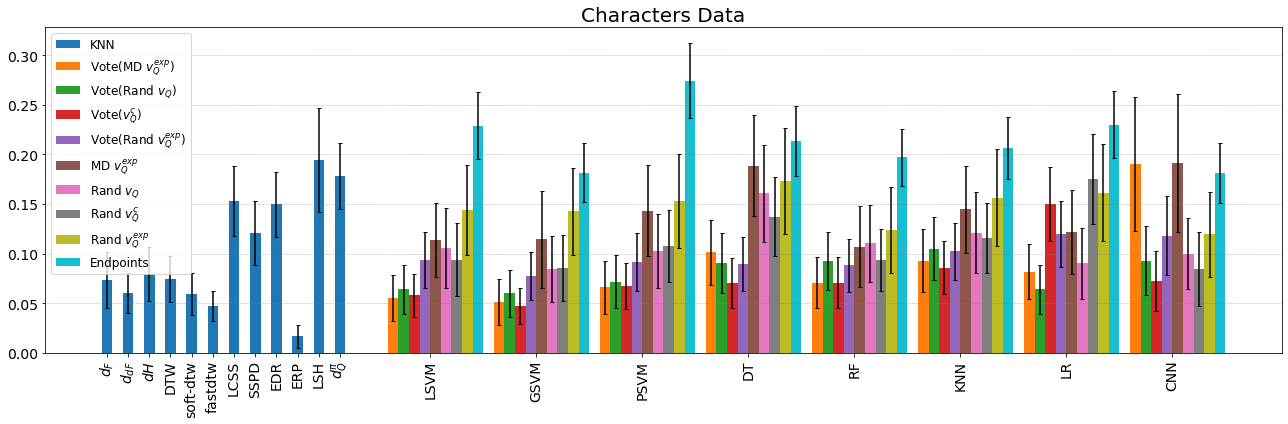

In [ ]:
width=0.1
index = np.arange(len(stds))
ind = np.arange(len(A)) + len(index) * 0.25

plt.subplots(figsize = (18, 6), tight_layout=True)
bars = [0] * 10

lower_lim = lower_limit_error(stds, errors)
bars[0] = plt.bar(index * 0.2, errors, width, yerr=[lower_lim, stds], capsize=2)

for i in range(len(FM)-1):
    lower_limit = lower_limit_error(C[i], B[i])
    bars[i+1] = plt.bar(ind+width*i-0.3, B[i], width, yerr=[lower_limit, C[i]], capsize=2)

plt.title('Characters Data', fontsize = 20)
plt.xticks(list(np.arange(len(stds)) * 0.2) + list(ind + 0.5 * width), 
           dists + labels, fontsize = 14)

plt.legend(tuple(bars), FM, loc=0, fontsize = 12)

plt.gca().yaxis.grid(color='gray', linestyle='dotted', linewidth=0.6)
plt.xticks(rotation='vertical', fontsize = 14)
plt.yticks(fontsize = 14)

path = '/content/gdrive/My Drive/Research/plots/plots characters/characters bar chart all horizontal.png'
plt.savefig(path, bbox_inches='tight', dpi=200)

plt.show()
